In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.seasonal import STL
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import levene
from scipy.stats import shapiro
from scipy.stats import pearsonr
import ppscore as pps
sns.set()

# Sales Data

## Load Data Sales Januari 
- Set order_date as datetime object
- rename order_date as date
- Set date as index

In [2]:
sales = pd.read_csv("Jan No Channel.csv")
sales['order_date'] = pd.to_datetime(sales['order_date'], format = '%d/%m/%Y')
sales.rename(columns = {'order_date' : 'date'}, inplace = True)
sales.set_index("date", inplace=True)
sales = sales.asfreq('d')
sales = sales.loc[:'2022-03-31']
sales

,sales_total,order_no,shipping_amount,shipping_discount_amount,qty
date,,,,,
2021-01-01,407403204,633,51411999.96,35233000.90,1770
2021-01-02,445345327,738,50072999.99,35661000.08,1965
2021-01-03,594148762,801,72007000.19,51539000.09,2260
2021-01-04,527649866,761,66817000.01,52830000.89,1937
2021-01-05,458552555,718,48697000.06,36431000.18,2225
...,...,...,...,...,...
2022-03-27,770474712,1013,36908000.03,22512000.04,2628
2022-03-28,831755420,994,39330000.44,24969000.49,2799
2022-03-29,882196402,1081,38926499.22,22801248.38,3232


In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2021-01-01 to 2022-03-31
Freq: D
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales_total               455 non-null    int64  
 1   order_no                  455 non-null    int64  
 2   shipping_amount           455 non-null    float64
 3   shipping_discount_amount  455 non-null    float64
 4   qty                       455 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 21.3 KB


## Plotting Sales Data

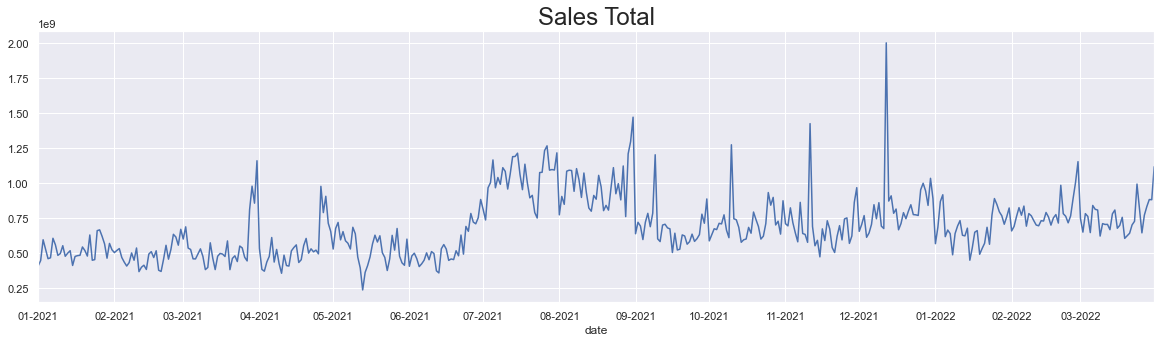

In [4]:
ax = sales.sales_total.plot(figsize = (20,5))
plt.title("Sales Total", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()

## ADF Test For Stationarity

In [5]:
sts.adfuller(sales.sales_total)

(-2.77861736006822,
 0.061393636885909625,
 6,
 448,
 {'1%': -3.4450311708077743,
  '5%': -2.8680131035505023,
  '10%': -2.570217924306441},
 17640.154470760113)

- Stationary hingga 10%
- Number of lags used in regression : 6. Ada autucorrelation going back 6 periods

## Check for Seasonality STL

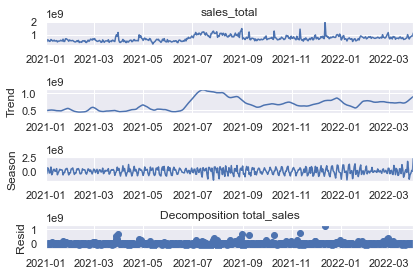

In [6]:
sales_dec_additive = STL(sales.sales_total, robust= True).fit()
sales_dec_additive.plot()
plt.title("Decomposition total_sales")
plt.show()

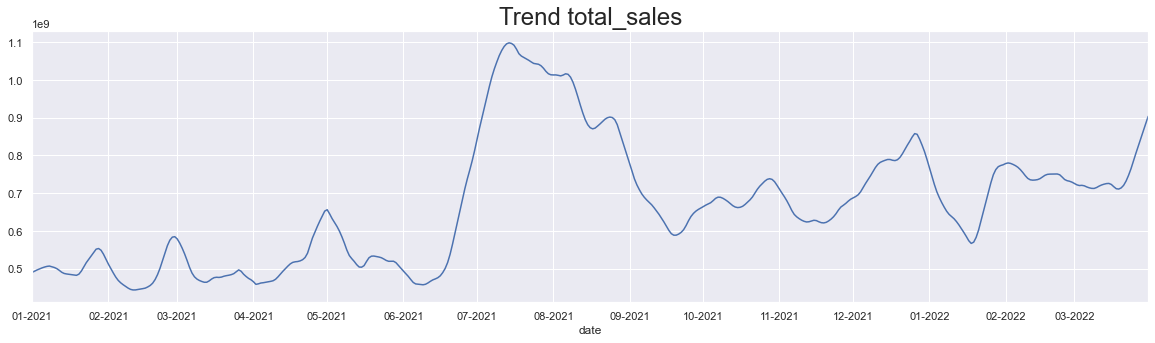

In [7]:
ax = sales_dec_additive.trend.plot(figsize = (20,5))
plt.title("Trend total_sales", size  = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()


- Juni-Juli 2021 --> PSBB
- Habis Juni-Juli Sales rata" lbh tinggi
- Desember naik (12/12,natal)

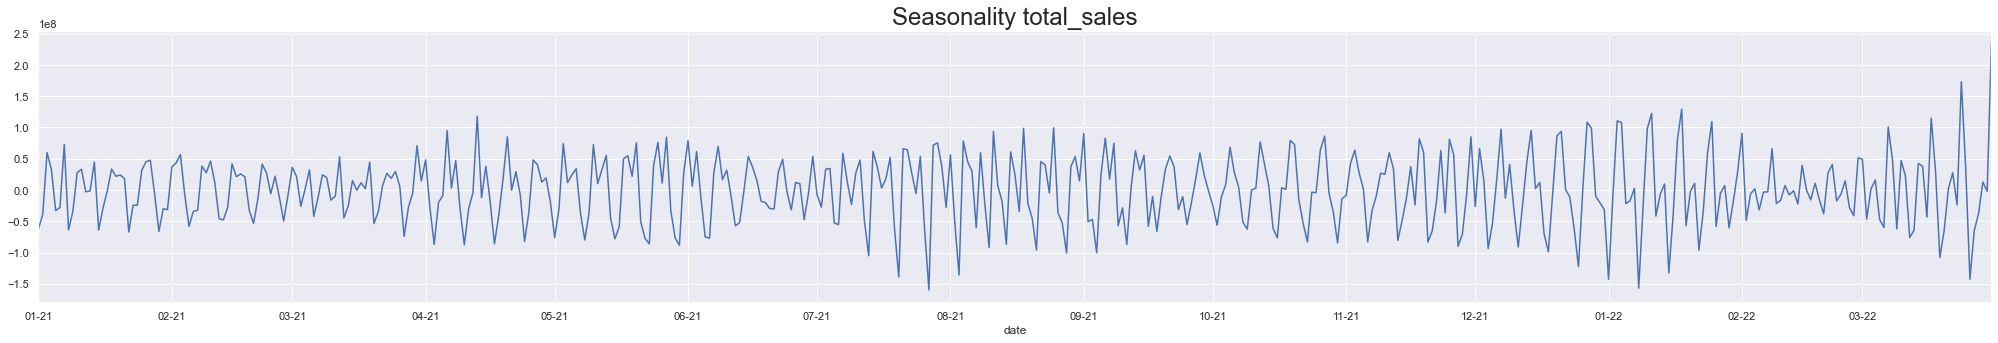

In [8]:
sales_dec_additive.seasonal.plot(figsize = (35,5))
plt.title("Seasonality total_sales", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()

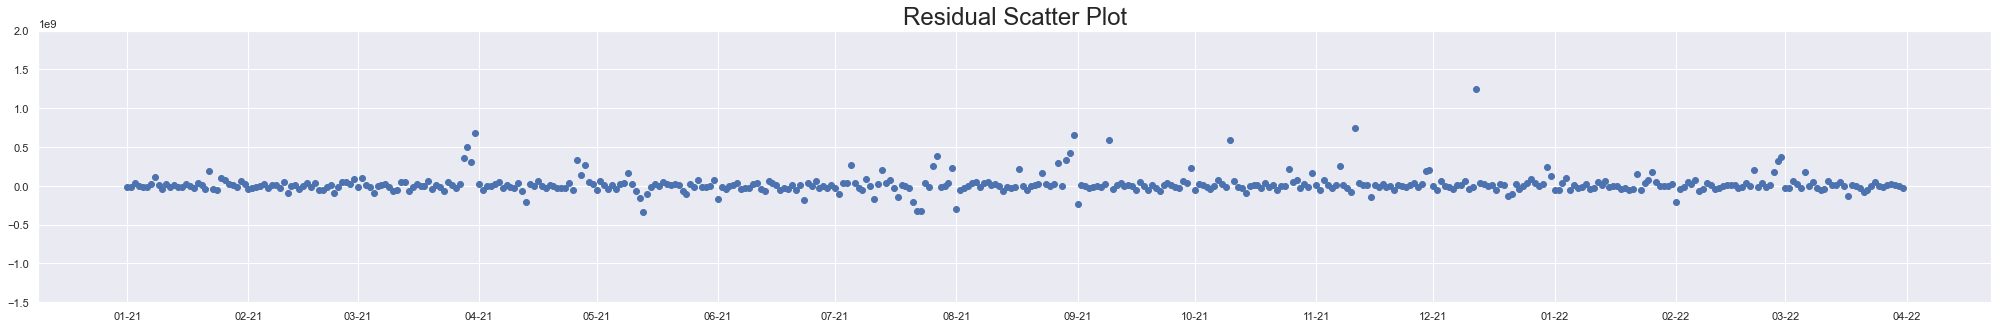

In [9]:
resid_STL = sales_dec_additive.resid
plt.figure(figsize=(35,5))
plt.title('Residual Scatter Plot', size = 24)
plt.scatter(resid_STL.index, resid_STL.values)
plt.ylim(-1500000000, 2000000000)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()


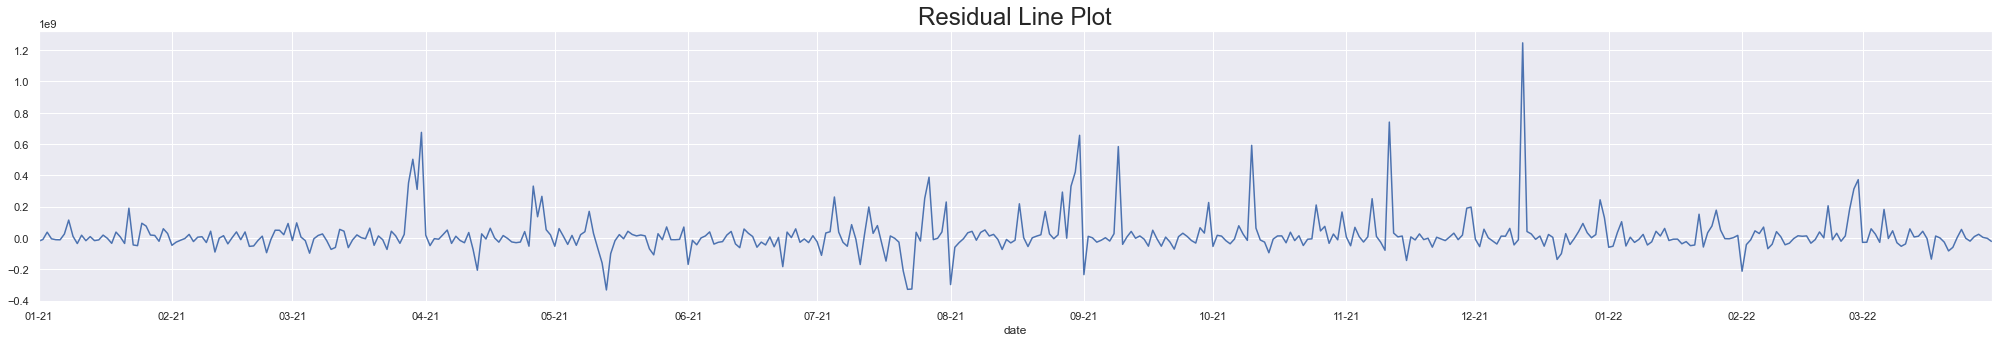

In [10]:
resid_STL.plot(figsize = (35,5))
plt.title("Residual Line Plot", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()

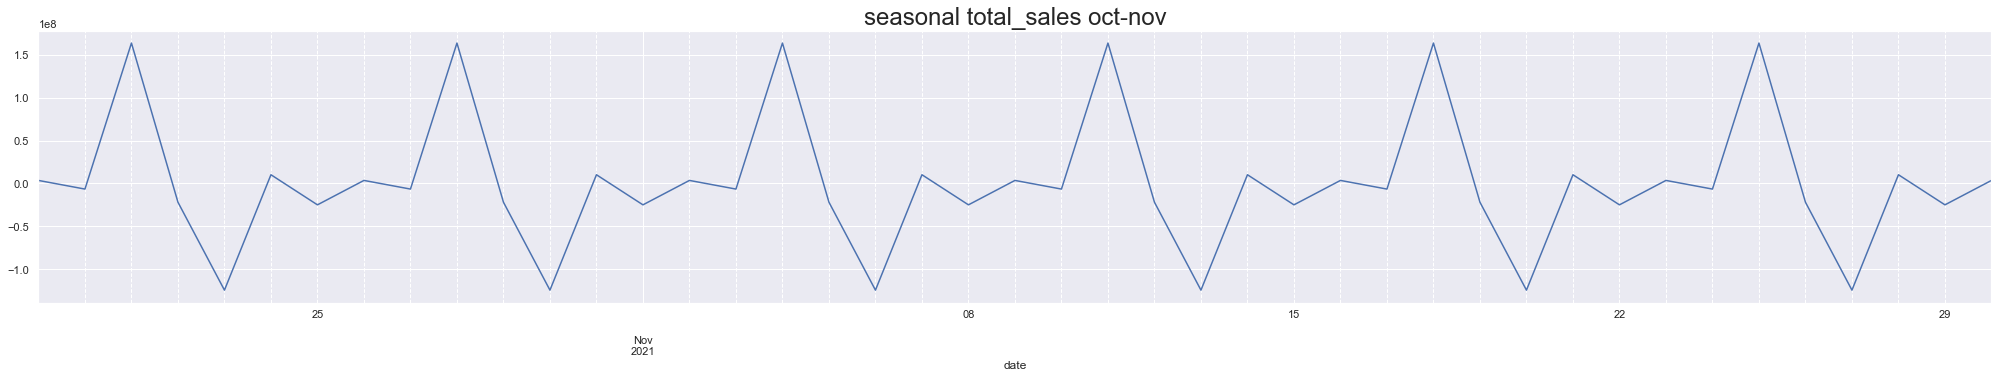

In [11]:
sales_q1 = sales.sales_total.loc['2021-10-19':'2021-11-30']
sales_q1_dec = seasonal_decompose(sales_q1, model = 'additive')
sales_q1_dec.seasonal.plot(figsize = (35,5))
plt.title("seasonal total_sales oct-nov", size = 24)
ax = plt.gca()
ax.grid(which='minor', axis='x', linestyle='--', color = 'white')
plt.show()

- Weekly Seasonality
- Senin-Selasa-Rabu ga terlalu beda, sharp rise di kamis(peak), drop smp sabtu, rise lumayan di minggu

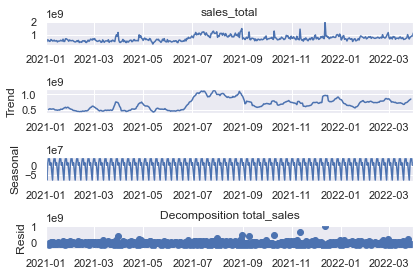

In [12]:
sales_dec_additive_sd = seasonal_decompose(sales.sales_total, model = 'additive')
sales_dec_additive_sd.plot()
plt.title("Decomposition total_sales")
plt.show()

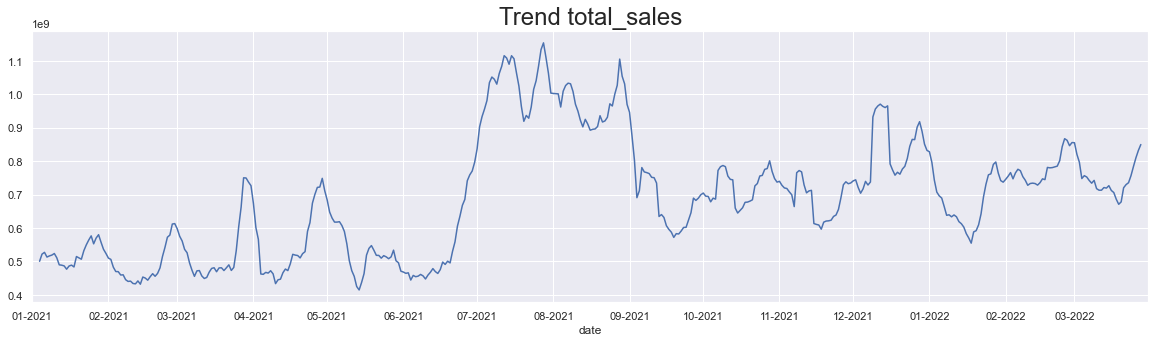

In [13]:
ax = sales_dec_additive_sd.trend.plot(figsize = (20,5))
plt.title("Trend total_sales", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()


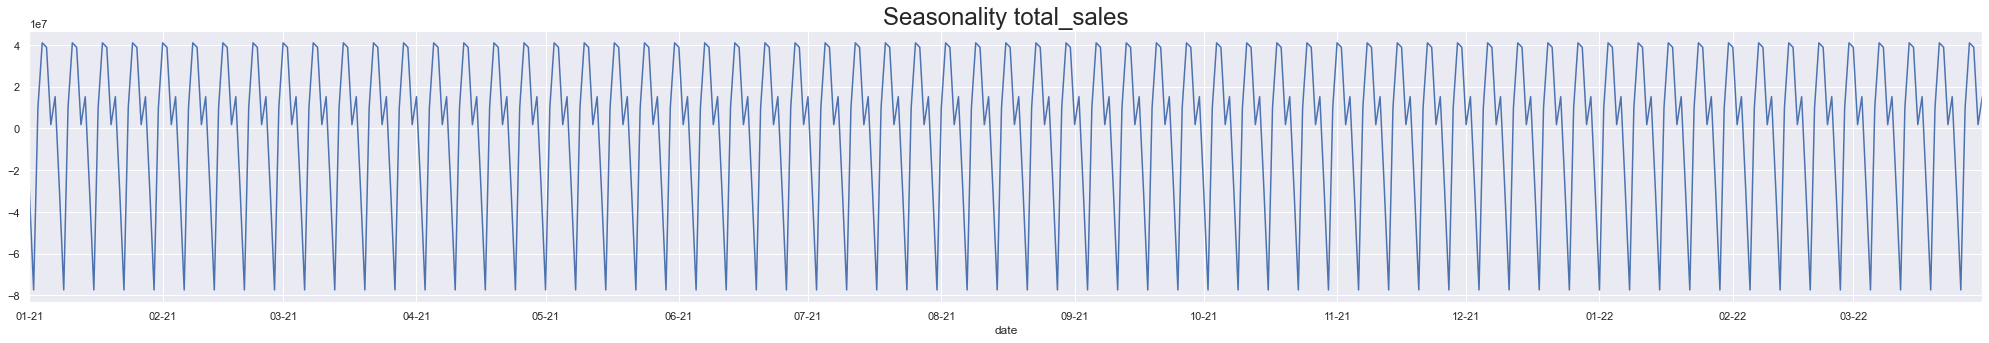

In [14]:
sales_dec_additive_sd.seasonal.plot(figsize = (35,5))
plt.title("Seasonality total_sales", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()

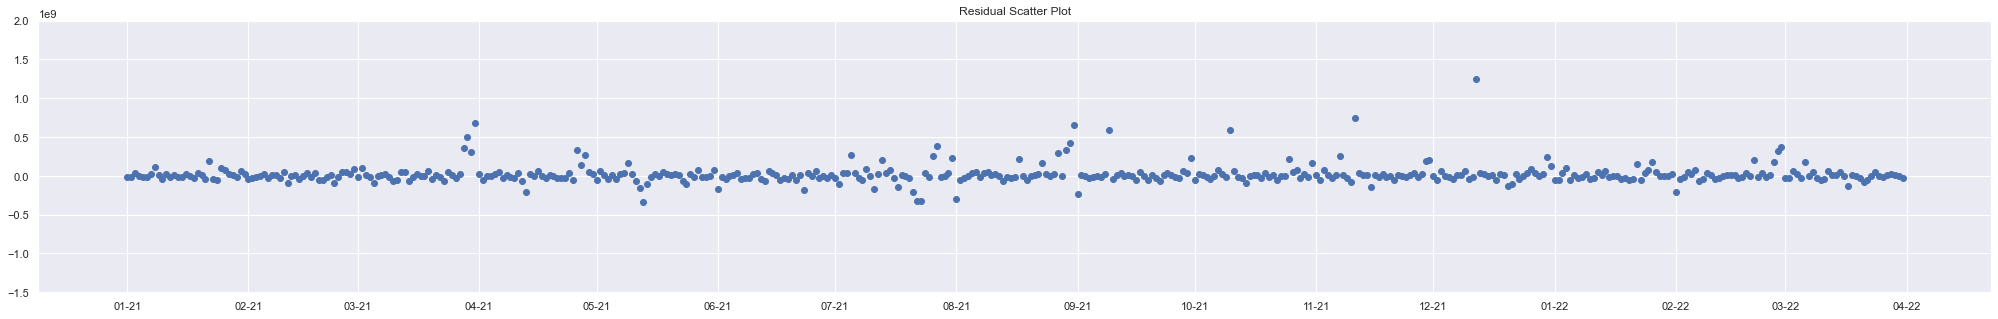

In [15]:
resid_sd = sales_dec_additive.resid
plt.figure(figsize=(35,5))
plt.title('Residual Scatter Plot')
plt.scatter(resid_sd.index, resid_sd.values)
plt.ylim(-1500000000, 2000000000)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()


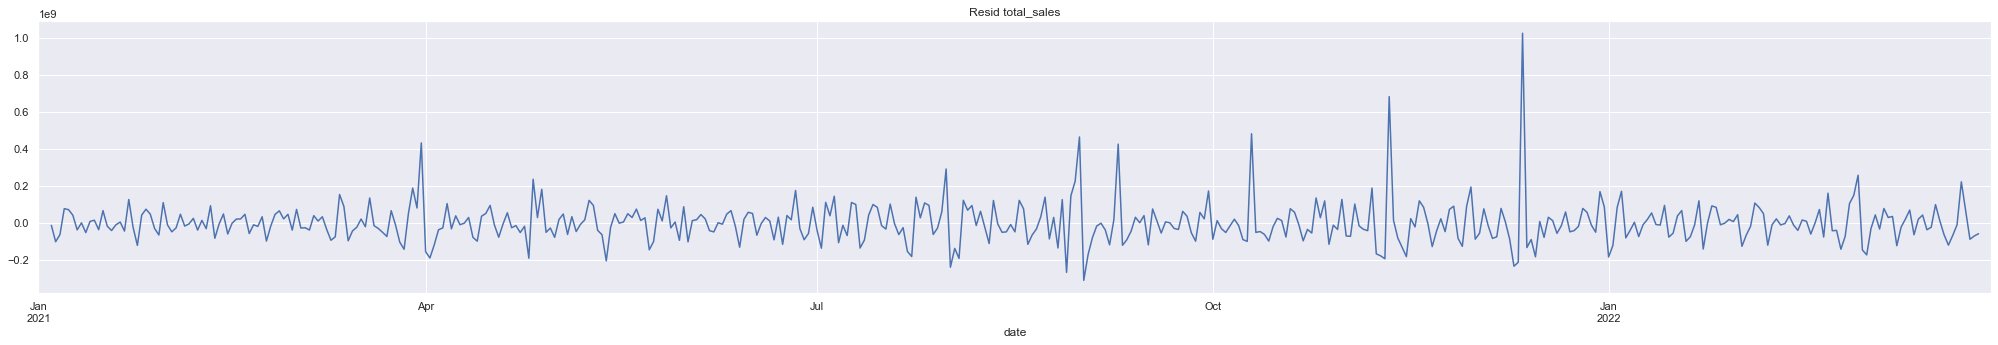

In [16]:
sales_dec_additive_sd.resid.plot(figsize = (35,5))
plt.title("Resid total_sales")
plt.show()

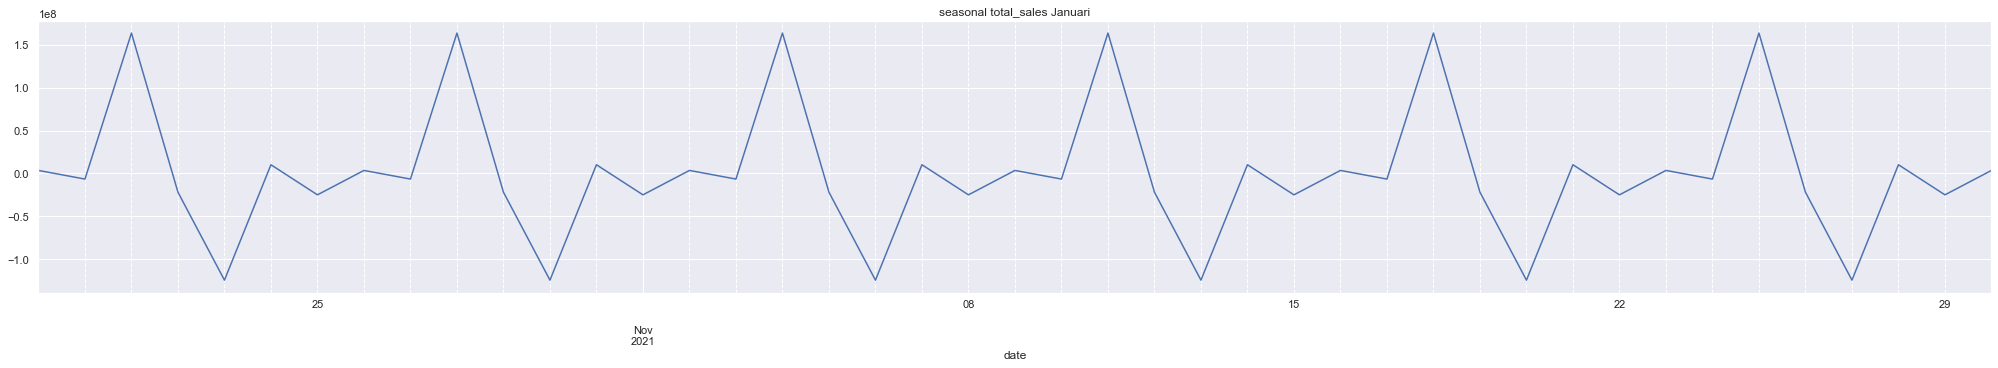

In [17]:
sales_q1_dec_sd = seasonal_decompose(sales_q1, model = 'additive')
sales_q1_dec_sd.seasonal.plot(figsize = (35,5))
plt.title("seasonal total_sales Januari")
ax = plt.gca()
ax.grid(which='minor', axis='x', linestyle='--', color = 'white')
plt.show()

## ACF

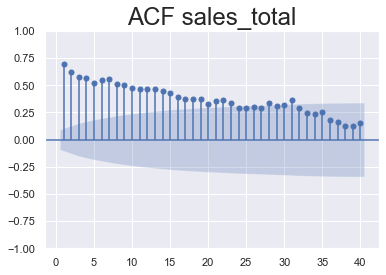

In [18]:
sgt.plot_acf(sales.sales_total, lags = 40, zero = False)
plt.title("ACF sales_total", size = 24)
plt.show()

## PACF

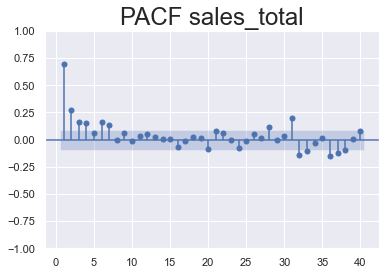

In [19]:
sgt.plot_pacf(sales.sales_total, lags = 40, zero = False, method = ('ols'))
plt.title("PACF sales_total", size = 24)
plt.show()

## Fitting Actual Data to Prediction Based on Seasonality & Trend

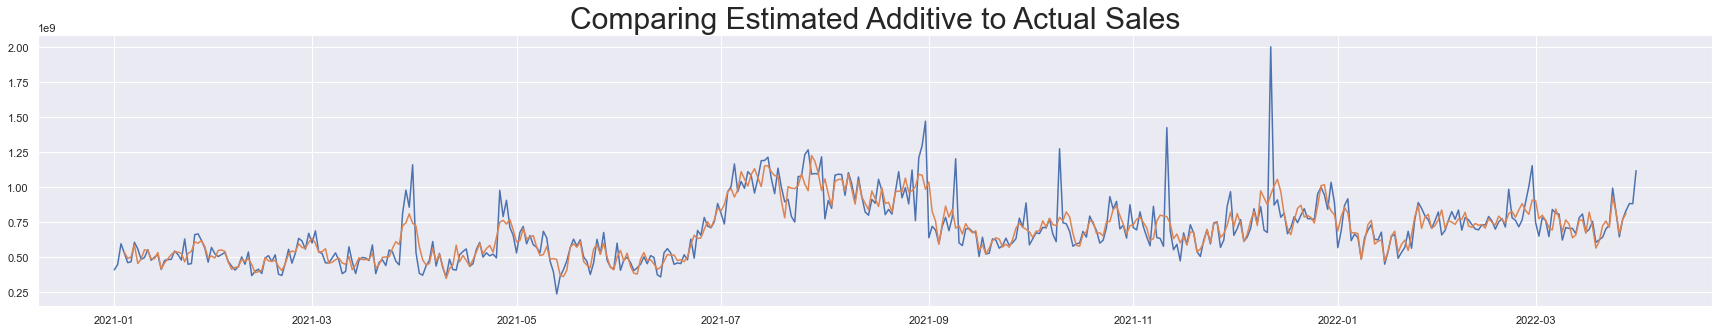

In [20]:
estimated_add = sales_dec_additive_sd.trend + sales_dec_additive.seasonal
plt.figure(figsize=(30,5))
plt.plot(sales.sales_total)
plt.plot(estimated_add)
plt.title('Comparing Estimated Additive to Actual Sales', size = 30)
plt.show()

## Detect Anomaly

### Residual Analysis

In [21]:
resid_mu = resid_STL.mean()
resid_dev = resid_STL.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

In [22]:
anomalies = sales.sales_total[(resid_STL < lower) | (resid_STL > upper)]
anomalies

date
2021-03-29     977898039
2021-03-31    1159882345
2021-08-30    1297039605
2021-08-31    1471960006
2021-09-09    1202797811
2021-10-10    1274380736
2021-11-11    1425709254
2021-12-12    2004027270
Name: sales_total, dtype: int64

In [23]:
anomaly_residu = resid_STL[(resid_STL < lower) | (resid_STL > upper)]
anomaly_residu

date
2021-03-29    5.032370e+08
2021-03-31    6.750047e+08
2021-08-30    4.224564e+08
2021-08-31    6.563140e+08
2021-09-09    5.840430e+08
2021-10-10    5.922011e+08
2021-11-11    7.406659e+08
2021-12-12    1.246763e+09
Name: resid, dtype: float64

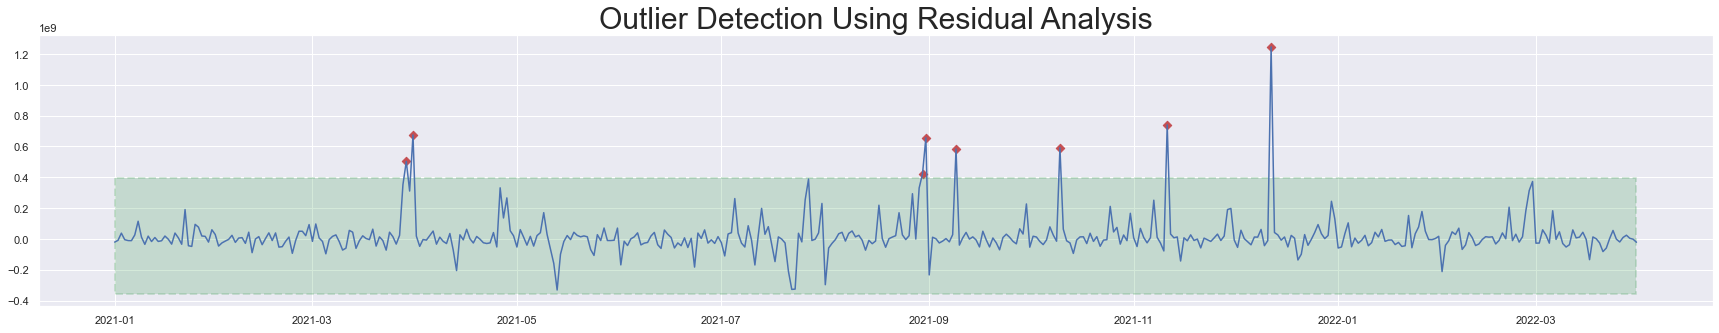

In [24]:
plt.figure(figsize=(30,5))
plt.plot(resid_STL)
plt.scatter(anomaly_residu.index, anomaly_residu.values, color='r', marker='D')
plt.fill_between([datetime(2021,1,1), datetime(2022,3,31)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.title('Outlier Detection Using Residual Analysis', size = 30)
plt.show()

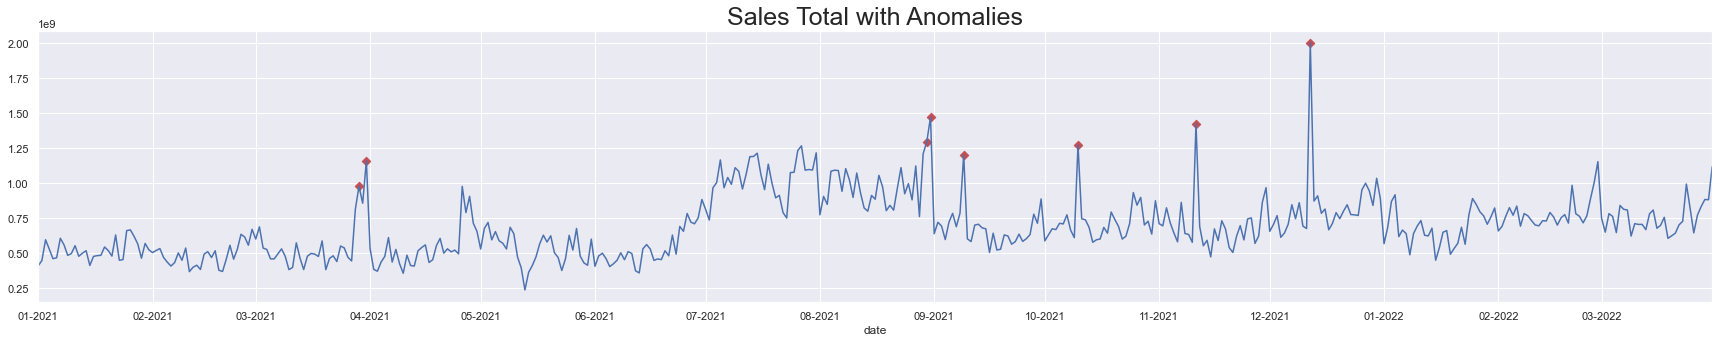

In [25]:
ax = sales.sales_total.plot(figsize = (30,5))
plt.scatter(anomalies.index, anomalies.values, color='r', marker='D')
plt.title('Sales Total with Anomalies', size = 25)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()

# Combine Traffic and Sales

In [26]:
traffic = pd.read_csv("Event Mixpanel Traffic.csv")
traffic['event_date'] = pd.to_datetime(traffic['event_date'], format = '%d/%m/%Y')
traffic = traffic.loc[:163]
traffic

,event_date,install_count,uninstall_count,session_rr_count,session_ace_count,session_informa_count,session_toys_kingdom_count,session_start_count
0,2021-10-19,1830,1275,24575,16384,9245,485,50689
1,2021-10-20,2001,1333,34986,23739,15381,734,74840
2,2021-10-21,1767,1283,34016,21223,13784,774,69797
3,2021-10-22,1695,1263,32508,20546,12706,726,66486
4,2021-10-23,1872,1187,32970,18536,12367,647,64520
...,...,...,...,...,...,...,...,...
159,2022-03-27,1653,612,24812,27477,21558,3181,77028
160,2022-03-28,1407,727,29360,19508,24508,3265,76641
161,2022-03-29,1734,688,30283,18244,19532,3841,71900
162,2022-03-30,1668,770,31722,13330,18457,2257,65766


In [27]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   event_date                  164 non-null    datetime64[ns]
 1   install_count               164 non-null    int64         
 2   uninstall_count             164 non-null    int64         
 3   session_rr_count            164 non-null    int64         
 4   session_ace_count           164 non-null    int64         
 5   session_informa_count       164 non-null    int64         
 6   session_toys_kingdom_count  164 non-null    int64         
 7   session_start_count         164 non-null    int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 10.4 KB


In [28]:
salesoct = pd.read_csv("Jan No Channel.csv")
salesoct['order_date'] = pd.to_datetime(salesoct['order_date'], format = '%d/%m/%Y')
salesoct = salesoct.loc[291:454]
salesoct

,order_date,sales_total,order_no,shipping_amount,shipping_discount_amount,qty
291,2021-10-19,792606185,811,36893498.98,24282500.08,2418
292,2021-10-20,738827095,896,41146999.85,27285499.87,2509
293,2021-10-21,688925899,845,39550500.01,25919000.00,2334
294,2021-10-22,599023636,725,35445500.18,26120243.20,1832
295,2021-10-23,619701664,807,29881000.15,20193500.12,2052
...,...,...,...,...,...,...
450,2022-03-27,770474712,1013,36908000.03,22512000.04,2628
451,2022-03-28,831755420,994,39330000.44,24969000.49,2799
452,2022-03-29,882196402,1081,38926499.22,22801248.38,3232
453,2022-03-30,880823307,1059,41502999.84,25574999.59,3211


In [29]:
salesoct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 291 to 454
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_date                164 non-null    datetime64[ns]
 1   sales_total               164 non-null    int64         
 2   order_no                  164 non-null    int64         
 3   shipping_amount           164 non-null    float64       
 4   shipping_discount_amount  164 non-null    float64       
 5   qty                       164 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 7.8 KB


In [30]:
df = pd.merge(salesoct, traffic, left_on='order_date', right_on='event_date')
df.drop(columns = ['event_date'], inplace = True)
df.rename(columns = {'order_date' : 'date'}, inplace = True)
df.set_index("date", inplace=True)
df.drop(columns = ['session_ace_count', 'session_informa_count', 'session_toys_kingdom_count'], inplace = True)
df

,sales_total,order_no,shipping_amount,shipping_discount_amount,qty,install_count,uninstall_count,session_rr_count,session_start_count
date,,,,,,,,,
2021-10-19,792606185,811,36893498.98,24282500.08,2418,1830,1275,24575,50689
2021-10-20,738827095,896,41146999.85,27285499.87,2509,2001,1333,34986,74840
2021-10-21,688925899,845,39550500.01,25919000.00,2334,1767,1283,34016,69797
2021-10-22,599023636,725,35445500.18,26120243.20,1832,1695,1263,32508,66486
2021-10-23,619701664,807,29881000.15,20193500.12,2052,1872,1187,32970,64520
...,...,...,...,...,...,...,...,...,...
2022-03-27,770474712,1013,36908000.03,22512000.04,2628,1653,612,24812,77028
2022-03-28,831755420,994,39330000.44,24969000.49,2799,1407,727,29360,76641
2022-03-29,882196402,1081,38926499.22,22801248.38,3232,1734,688,30283,71900


# Traffic Data

## Plotting Traffic Data

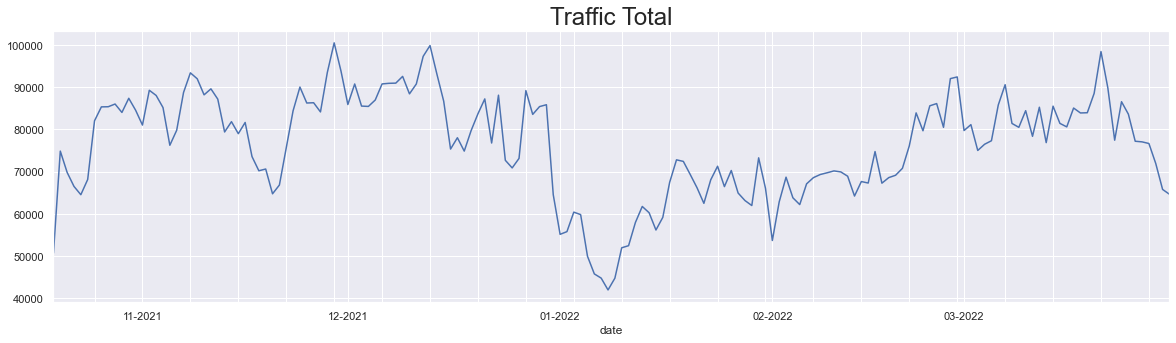

In [31]:
ax = df.session_start_count.plot(figsize = (20,5))
plt.title("Traffic Total", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()

## ADF Test For Stationarity

In [32]:
sts.adfuller(df.session_start_count)

(-3.6371352669707426,
 0.005089504259636961,
 0,
 163,
 {'1%': -3.471118535474365,
  '5%': -2.8794405060097024,
  '10%': -2.576313761526591},
 3008.42440513883)

- Since t-stat < semua critical value kecuali 1% maka session_start_count Stationer
- Number of lags used in regression : 7. Ada autocorrelation going back 7 periods

## Check for Seasonality STL

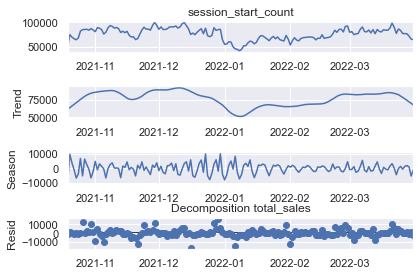

In [33]:
traffic_dec_additive = STL(df.session_start_count,robust = True).fit()
traffic_dec_additive.plot()
plt.title("Decomposition total_sales")
plt.show()

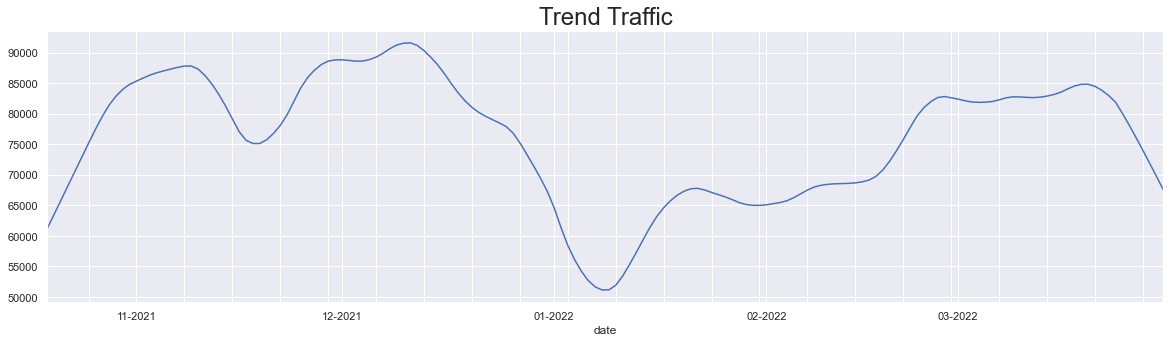

In [34]:
ax = traffic_dec_additive.trend.plot(figsize = (20,5))
plt.title("Trend Traffic", size  = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()


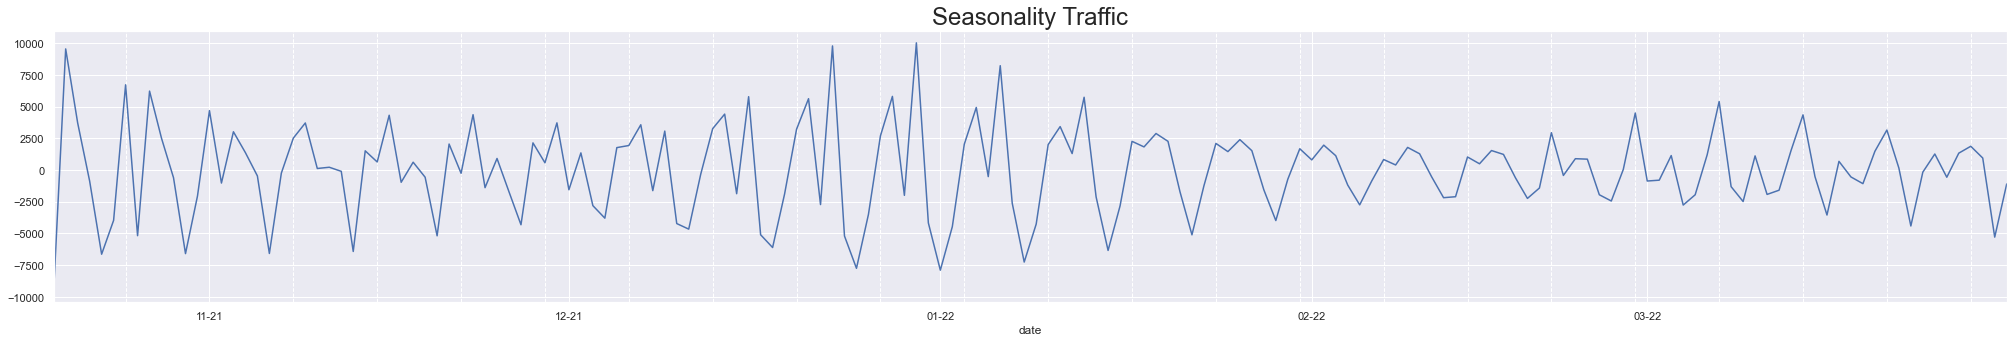

In [35]:
traffic_dec_additive.seasonal.plot(figsize = (35,5))
plt.title("Seasonality Traffic", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()

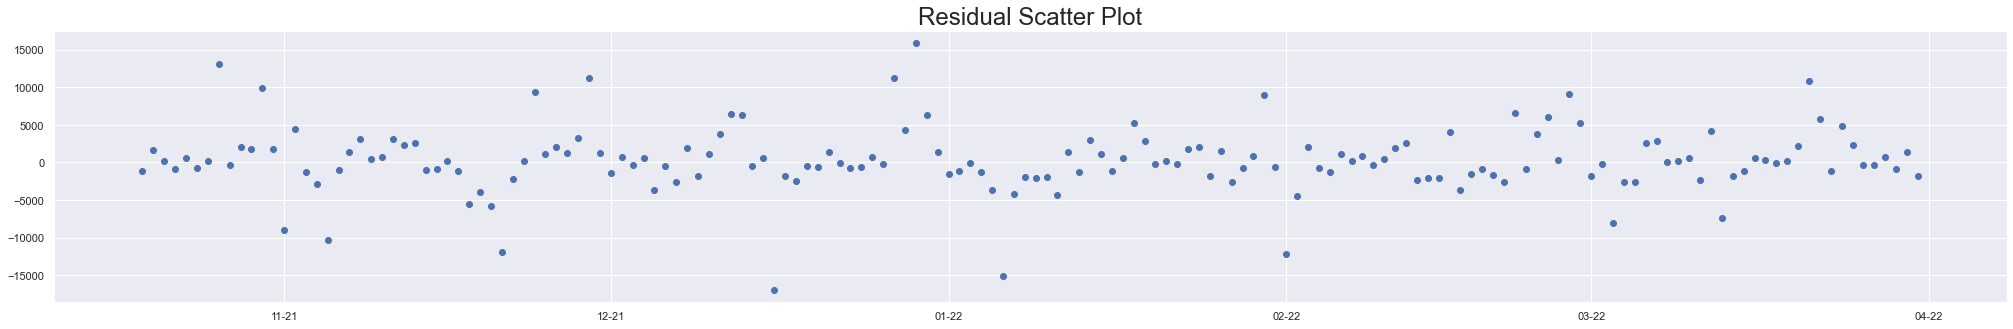

In [36]:
resid_traffic_STL = traffic_dec_additive.resid
plt.figure(figsize=(35,5))
plt.title('Residual Scatter Plot', size = 24)
plt.scatter(resid_traffic_STL.index, resid_traffic_STL.values)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()


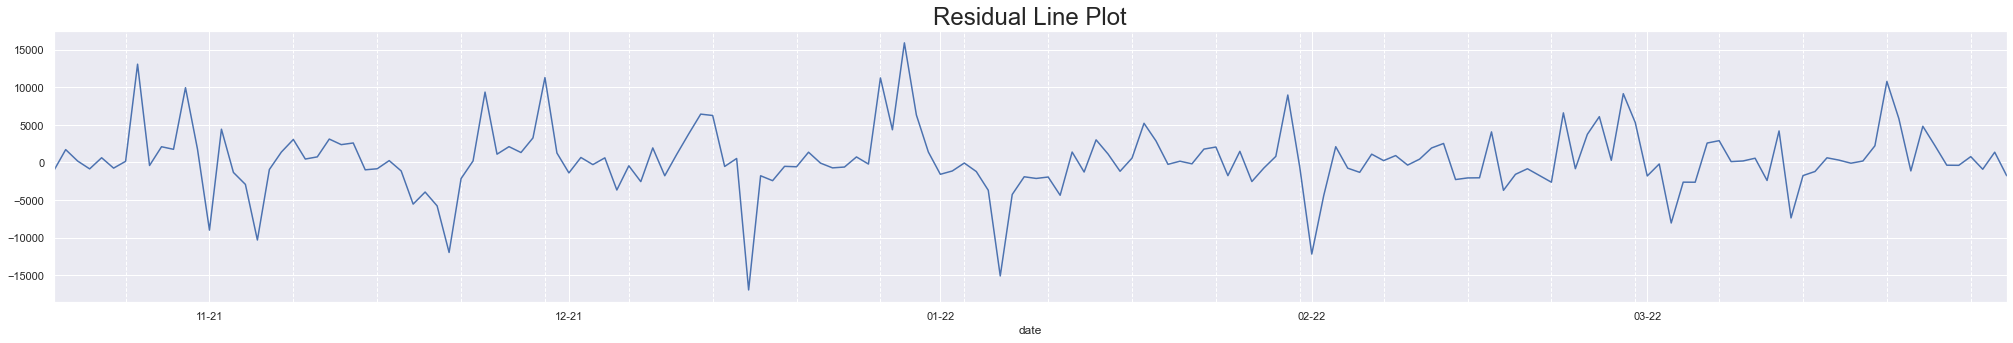

In [37]:
resid_traffic_STL.plot(figsize = (35,5))
plt.title("Residual Line Plot", size = 24)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
dateFMT = plt.matplotlib.dates.DateFormatter('%m-%y')
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFMT)
ax.grid(which='minor', axis='both', linestyle='--')
plt.show()

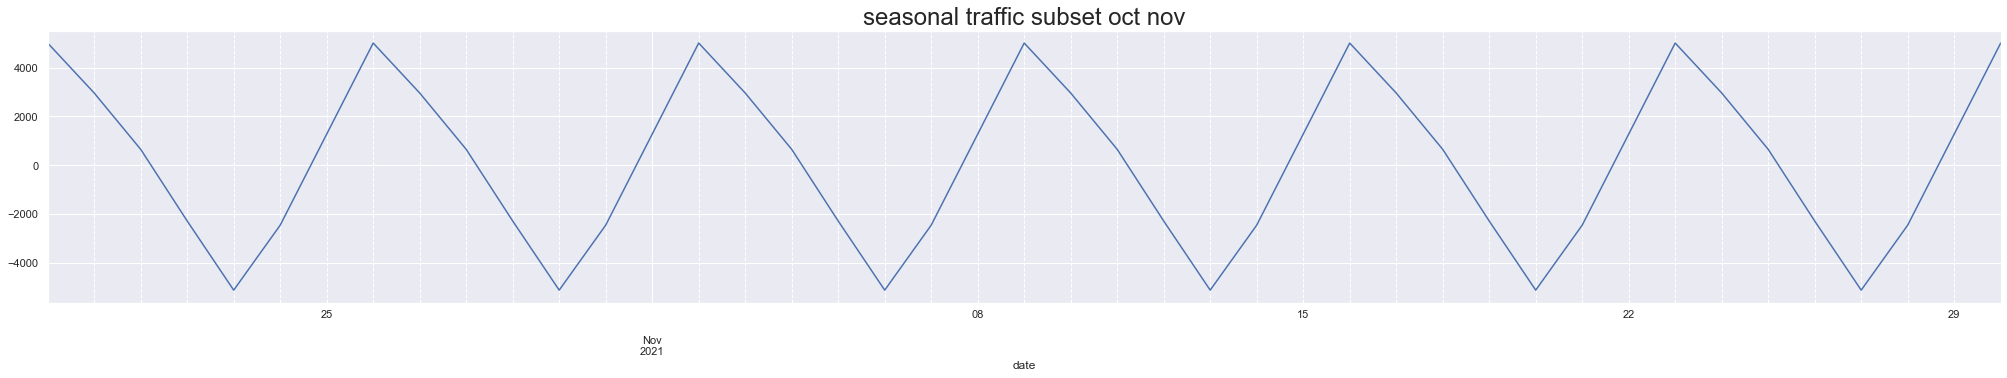

In [38]:
traffic_21 = df.session_start_count.loc[:'2021-11-30']
traffic_21_dec = seasonal_decompose(traffic_21, model = 'additive')
traffic_21_dec.seasonal.plot(figsize = (35,5))
plt.title("seasonal traffic subset oct nov", size = 24)
ax = plt.gca()
ax.grid(which='minor', axis='x', linestyle='--', color = 'white')
plt.show()

- Weekly Seasonality
- Peak di Selasa --> Drop smp bottom di Sabtu -- > Minggu Senin Sharp Rise

## ACF

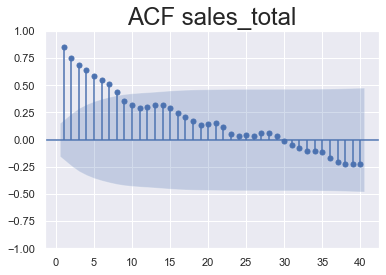

In [39]:
sgt.plot_acf(df.session_start_count, lags = 40, zero = False)
plt.title("ACF sales_total", size = 24)
plt.show()

## PACF

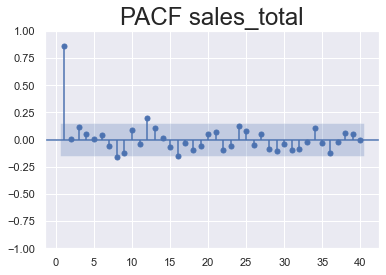

In [40]:
sgt.plot_pacf(df.session_start_count, lags = 40, zero = False, method = ('ols'))
plt.title("PACF sales_total", size = 24)
plt.show()

## Fitting Actual Data to Prediction Based on Seasonality & Trend

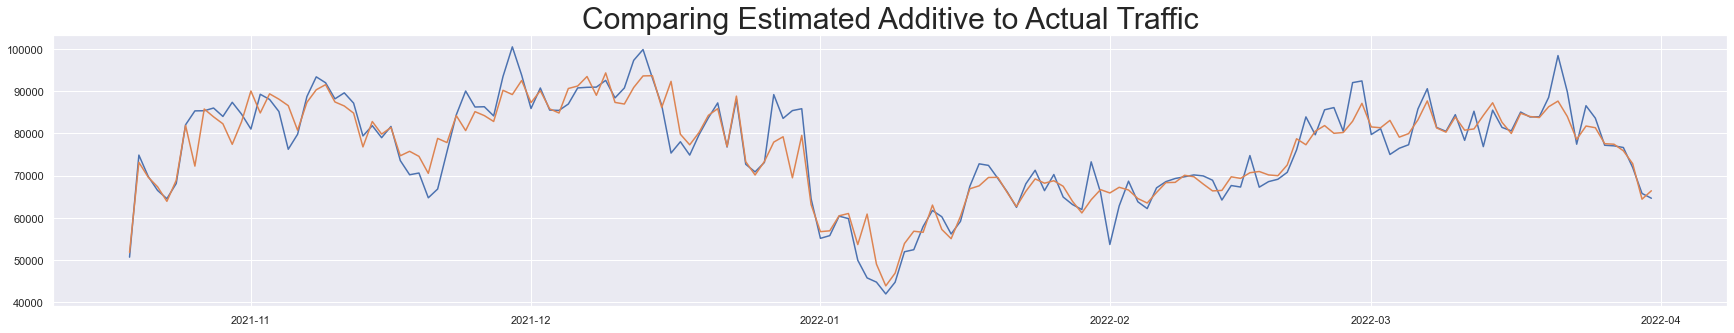

In [41]:
estimated_add = traffic_dec_additive.trend + traffic_dec_additive.seasonal
plt.figure(figsize=(30,5))
plt.plot(df.session_start_count)
plt.plot(estimated_add)
plt.title('Comparing Estimated Additive to Actual Traffic', size = 30)
plt.show()

## Detect Anomaly

## Residual Analysis

In [42]:
resid_mu = resid_traffic_STL.mean()
resid_dev = resid_traffic_STL.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

In [43]:
anomalies_tf = df.session_start_count[(resid_traffic_STL < lower) | (resid_traffic_STL > upper)]
anomalies_tf

date
2021-12-16    75325
2021-12-29    85377
2022-01-06    45776
Name: session_start_count, dtype: int64

In [44]:
anomaly_residu_tf = resid_traffic_STL[(resid_traffic_STL < lower) | (resid_traffic_STL > upper)]
anomaly_residu_tf

date
2021-12-16   -16973.204735
2021-12-29    15912.790658
2022-01-06   -15109.267760
Name: resid, dtype: float64

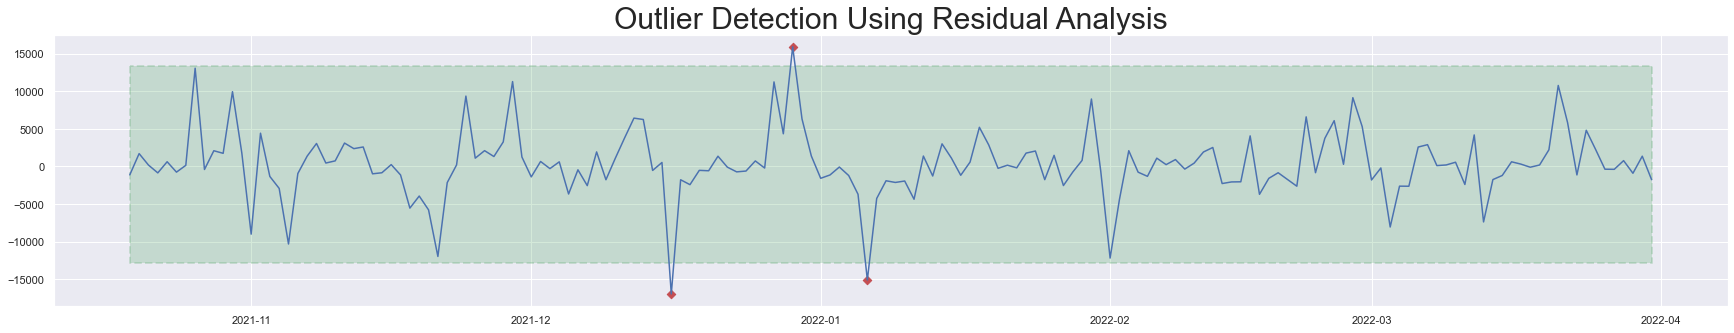

In [45]:
plt.figure(figsize=(30,5))
plt.plot(resid_traffic_STL)
plt.scatter(anomaly_residu_tf.index, anomaly_residu_tf.values, color='r', marker='D')
plt.fill_between([datetime(2021,10,19), datetime(2022,3,31)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.title('Outlier Detection Using Residual Analysis', size = 30)
plt.show()

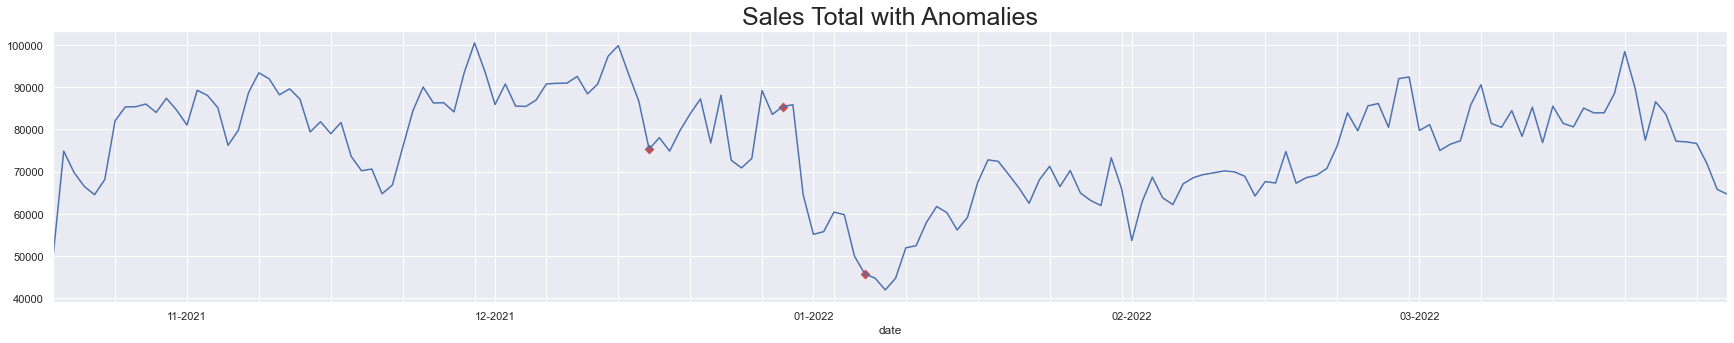

In [46]:
ax = df.session_start_count.plot(figsize = (30,5))
plt.scatter(anomalies_tf.index, anomalies_tf.values, color='r', marker='D')
plt.title('Sales Total with Anomalies', size = 25)
years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
monthsFMT = plt.matplotlib.dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFMT)
ax.grid(which='minor', axis='both')
plt.show()

# Check Relationship Between Variables

## Correlation Matrix

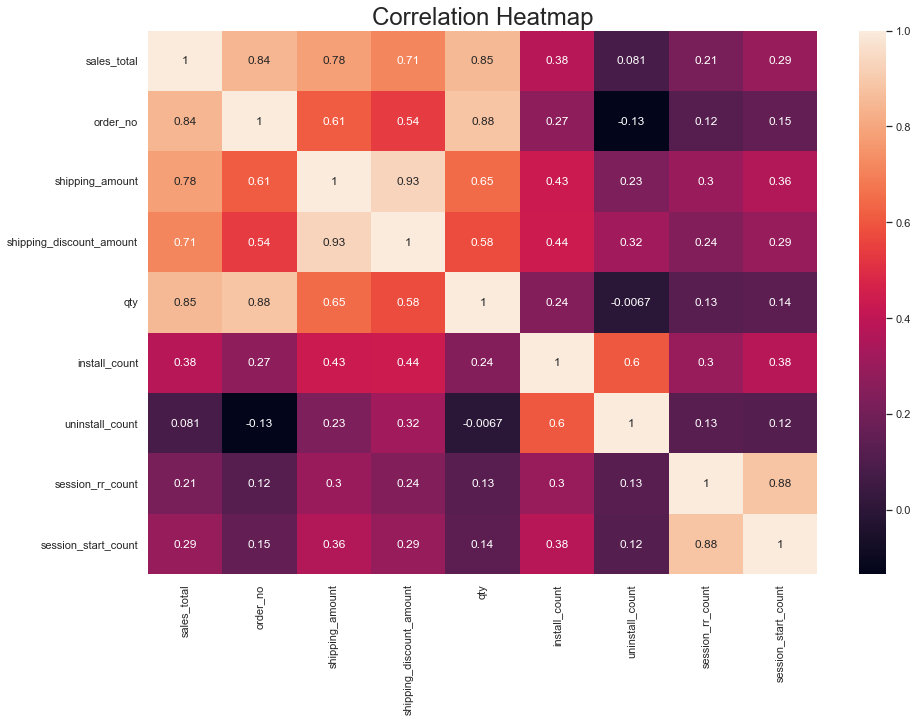

In [47]:
plt.figure(figsize=(15,10))
cor = df.corr()
sns.heatmap(cor,annot=True)
plt.title("Correlation Heatmap", size = 24)
plt.show()

## Predictive Power Score

In [48]:
pps.predictors(df, 'sales_total')

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,qty,sales_total,0.136126,regression,True,mean absolute error,1.052809e+08,9.094950e+07,DecisionTreeRegressor()
1,shipping_amount,sales_total,0.079320,regression,True,mean absolute error,1.052809e+08,9.693000e+07,DecisionTreeRegressor()
2,order_no,sales_total,0.000000,regression,True,mean absolute error,1.052809e+08,1.060351e+08,DecisionTreeRegressor()
3,shipping_discount_amount,sales_total,0.000000,regression,True,mean absolute error,1.052809e+08,1.092690e+08,DecisionTreeRegressor()
4,install_count,sales_total,0.000000,regression,True,mean absolute error,1.052809e+08,1.412643e+08,DecisionTreeRegressor()
5,uninstall_count,sales_total,0.000000,regression,True,mean absolute error,1.052809e+08,1.568306e+08,DecisionTreeRegressor()
6,session_rr_count,sales_total,0.000000,regression,True,mean absolute error,1.052809e+08,1.472629e+08,DecisionTreeRegressor()
7,session_start_count,sales_total,0.000000,regression,True,mean absolute error,1.052809e+08,1.494164e+08,DecisionTreeRegressor()


## T-Test Median

In [49]:
def ttest(data):
    med = np.median(data)
    b = stats.ttest_1samp(a=data, popmean=med)
    if b.pvalue > 0.05:
        print("Fail to Reject H0")
    else:
        print("Reject H0")

In [50]:
ttest(df.sales_total)
ttest(df.order_no)
ttest(df.shipping_amount)
ttest(df.shipping_discount_amount)
ttest(df.qty)
ttest(df.install_count)
ttest(df.uninstall_count)
ttest(df.session_rr_count)
ttest(df.session_start_count)

Fail to Reject H0
Fail to Reject H0
Fail to Reject H0
Reject H0
Fail to Reject H0
Fail to Reject H0
Reject H0
Fail to Reject H0
Fail to Reject H0


Fail to reject H0 buat semua column kecuali  "uninstall_count",    "shipping_discount_amount"

## Robust Scaler Normalization

In [51]:
rs = RobustScaler()
data = df.values
scaled_df = pd.DataFrame(rs.fit_transform(data),columns = ['sales_total', 'order_no','shipping_amount','shipping_discount_amount','qty','install_count','uninstall_count','session_rr_count','session_start_count'])
scaled_df
#df1= pd.DataFrame(columns = ['sales_total', 'order_no','shipping_amount','shipping_discount_amount','qty','install_count','uninstall_count','session_rr_count','session_start_count'])
#df1

,sales_total,order_no,shipping_amount,shipping_discount_amount,qty,install_count,uninstall_count,session_rr_count,session_start_count
0,0.417760,-0.687664,0.059761,0.392410,-0.312063,2.087845,5.033159,-1.067940,-1.494808
1,0.071922,-0.241470,0.581719,0.921002,-0.152972,2.786517,5.438045,-0.223628,-0.141110
2,-0.248979,-0.509186,0.385808,0.680469,-0.458916,1.830439,5.089005,-0.302293,-0.423777
3,-0.827115,-1.139108,-0.117927,0.715892,-1.336538,1.536261,4.949389,-0.424589,-0.609363
4,-0.694140,-0.708661,-0.800761,-0.327342,-0.951923,2.259448,4.418848,-0.387122,-0.719561
...,...,...,...,...,...,...,...,...,...
159,0.275439,0.372703,0.061540,0.080764,0.055070,1.364658,0.404887,-1.048720,-0.018469
160,0.669518,0.272966,0.358750,0.513249,0.354021,0.359551,1.207679,-0.679886,-0.040161
161,0.993889,0.729659,0.309236,0.131678,1.111014,1.695608,0.935428,-0.605032,-0.305901
162,0.985059,0.614173,0.625405,0.619918,1.074301,1.425945,1.507853,-0.488332,-0.649720


## ANOVA

  ### Testing for Assumptions

In [52]:
df.columns

Index(['sales_total', 'order_no', 'shipping_amount',
       'shipping_discount_amount', 'qty', 'install_count', 'uninstall_count',
       'session_rr_count', 'session_start_count'],
      dtype='object')

array([[<AxesSubplot:title={'center':'sales_total'}>,
        <AxesSubplot:title={'center':'order_no'}>,
        <AxesSubplot:title={'center':'shipping_amount'}>],
       [<AxesSubplot:title={'center':'shipping_discount_amount'}>,
        <AxesSubplot:title={'center':'qty'}>,
        <AxesSubplot:title={'center':'install_count'}>],
       [<AxesSubplot:title={'center':'uninstall_count'}>,
        <AxesSubplot:title={'center':'session_rr_count'}>,
        <AxesSubplot:title={'center':'session_start_count'}>]],
      dtype=object)

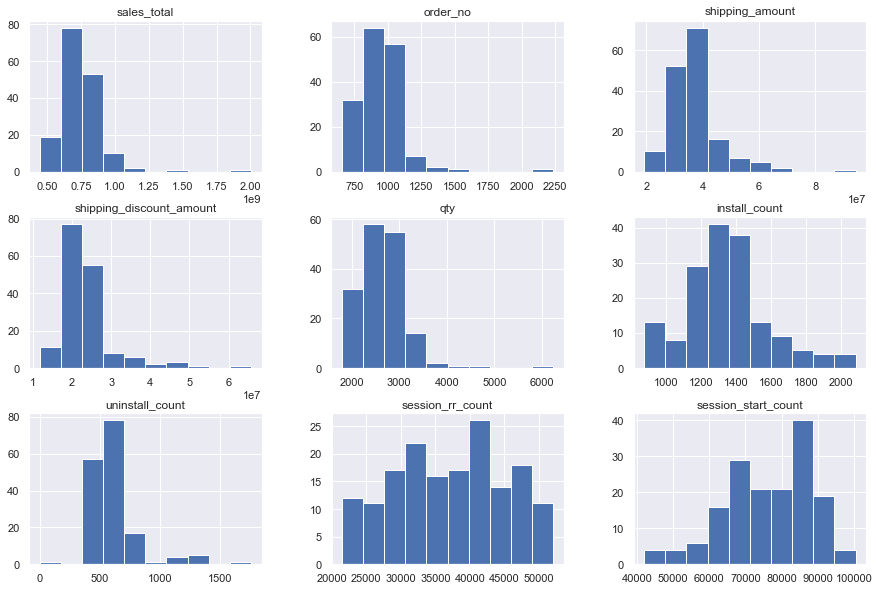

In [53]:
df.hist(figsize = (15,10))

array([[<AxesSubplot:title={'center':'sales_total'}>,
        <AxesSubplot:title={'center':'order_no'}>,
        <AxesSubplot:title={'center':'shipping_amount'}>],
       [<AxesSubplot:title={'center':'shipping_discount_amount'}>,
        <AxesSubplot:title={'center':'qty'}>,
        <AxesSubplot:title={'center':'install_count'}>],
       [<AxesSubplot:title={'center':'uninstall_count'}>,
        <AxesSubplot:title={'center':'session_rr_count'}>,
        <AxesSubplot:title={'center':'session_start_count'}>]],
      dtype=object)

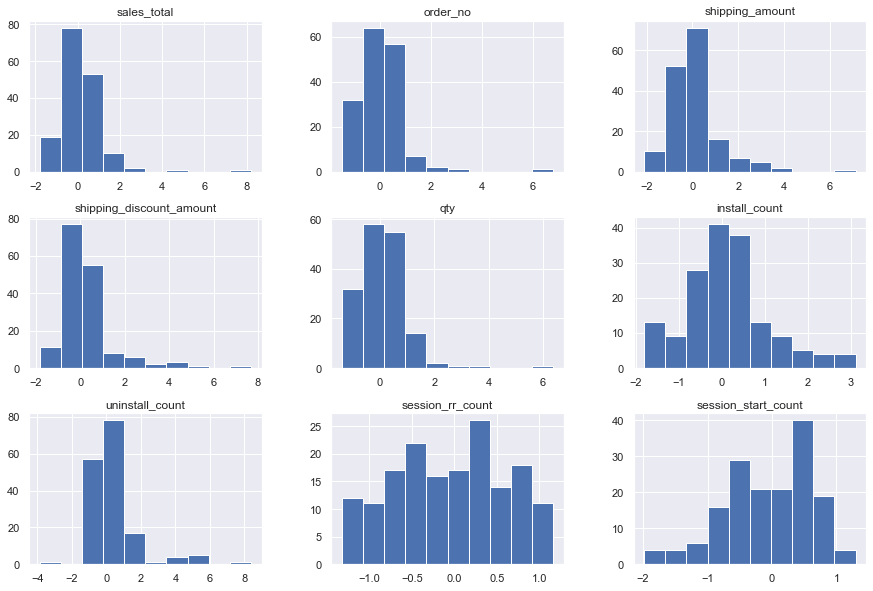

In [54]:
scaled_df.hist(figsize = (15,10))

### Levene

In [55]:
levene(df.sales_total,df.order_no,df.shipping_amount,df.shipping_discount_amount,df.qty,df.install_count,df.uninstall_count,df.session_rr_count,df.session_start_count, center='median')

LeveneResult(statistic=106.03590846180244, pvalue=1.4298412683229358e-139)

In [56]:
levene(scaled_df.sales_total,scaled_df.order_no,scaled_df.shipping_amount,scaled_df.shipping_discount_amount,scaled_df.qty,scaled_df.install_count,scaled_df.uninstall_count,scaled_df.session_rr_count,scaled_df.session_start_count, center= 'median')

LeveneResult(statistic=2.605889002455738, pvalue=0.007863452300304706)

- Scaled_df p value < 0.05 --> Non-homogenous variance

### Shapiro Wilk

In [57]:
def shap(data):
    b = shapiro(data)
    if b.pvalue > 0.05:
        print("Fail to Reject H0")
    else:
        print("Reject H0")

In [58]:
shap(scaled_df.sales_total)
shap(scaled_df.order_no)
shap(scaled_df.shipping_amount)
shap(scaled_df.shipping_discount_amount)
shap(scaled_df.qty)
shap(scaled_df.install_count)
shap(scaled_df.uninstall_count)
shap(scaled_df.session_rr_count)
shap(scaled_df.session_start_count)

Reject H0
Reject H0
Reject H0
Reject H0
Reject H0
Reject H0
Reject H0
Reject H0
Reject H0


- Data Not Normal

### Pearson Rank

In [59]:
def pearr(y,x):
    b = pearsonr(y,x)
    if b[1] > 0.05:
        print("Fail to Reject H0")
    else:
        print("Reject H0")

In [60]:
pearr(scaled_df.sales_total,scaled_df.order_no)
pearr(scaled_df.sales_total,scaled_df.shipping_amount)
pearr(scaled_df.sales_total,scaled_df.shipping_discount_amount)
pearr(scaled_df.sales_total,scaled_df.qty)
pearr(scaled_df.sales_total,scaled_df.install_count)
pearr(scaled_df.sales_total,scaled_df.uninstall_count)
pearr(scaled_df.sales_total,scaled_df.session_rr_count)
pearr(scaled_df.sales_total,scaled_df.session_start_count)

Reject H0
Reject H0
Reject H0
Reject H0
Reject H0
Fail to Reject H0
Reject H0
Reject H0


- Ada Dependency

## One Way Anova

In [61]:
X = df.drop(columns = ['sales_total'])
Y = df['sales_total']

<AxesSubplot:>

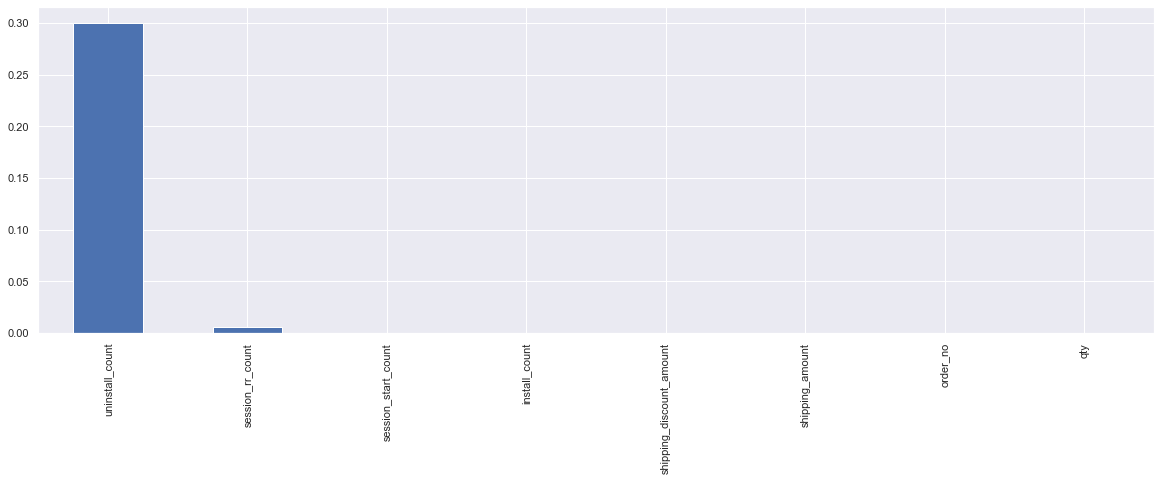

In [62]:
univariate = f_regression(X.fillna(0), Y)
univariate = pd.Series(univariate[1])
univariate.index = X.columns
univariate.sort_values(ascending=False).plot.bar(figsize=(20,6))

In [63]:
Xs = scaled_df.drop(columns = ['sales_total'])
Ys = scaled_df['sales_total']

<AxesSubplot:>

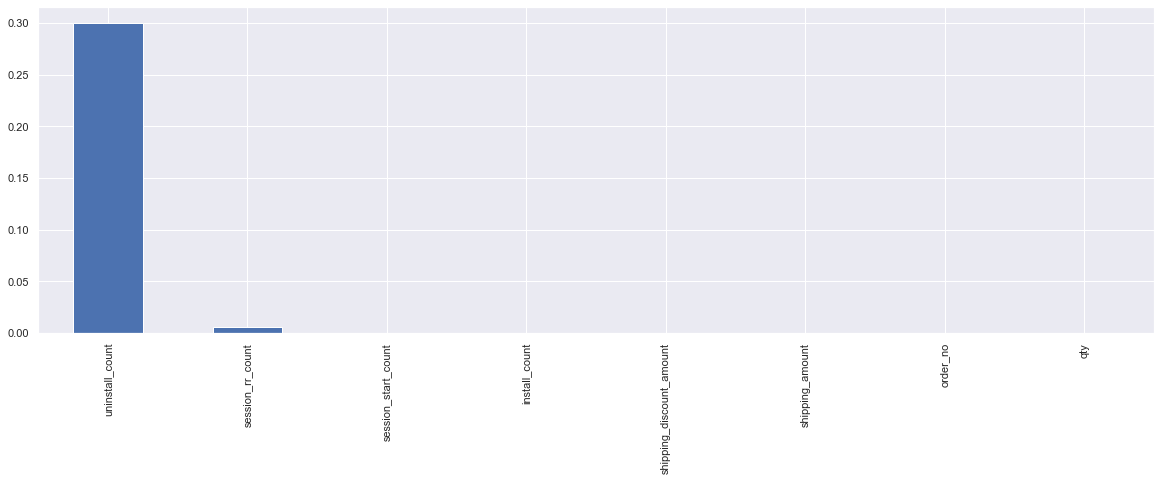

In [64]:
univariate = f_regression(Xs.fillna(0), Ys)
univariate = pd.Series(univariate[1])
univariate.index = Xs.columns
univariate.sort_values(ascending=False).plot.bar(figsize=(20,6))

## Mutual Info

Text(0, 0.5, 'Mutual Information')

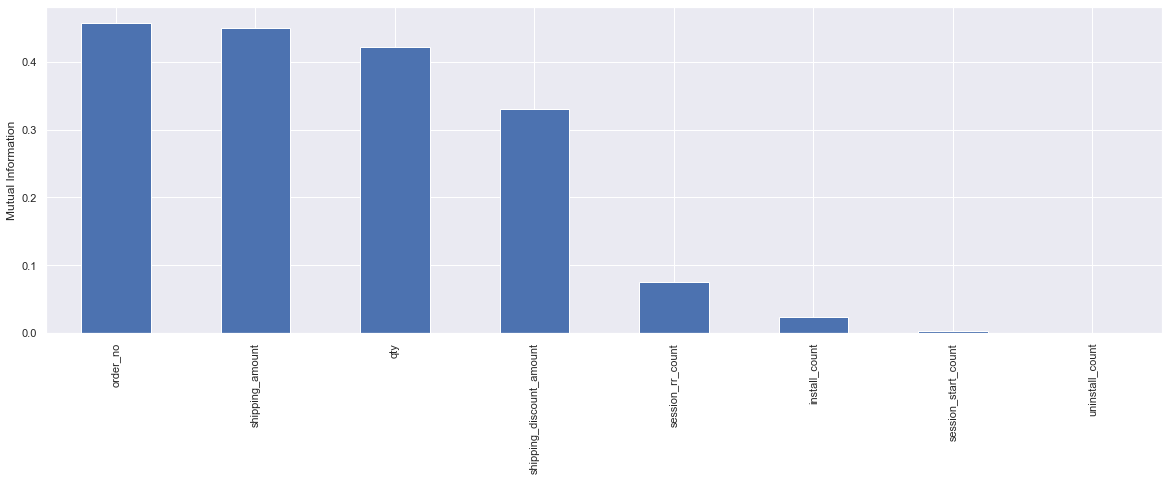

In [65]:
# determine the mutual information
mi = mutual_info_regression(X,Y)

# and make a bar  plot
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

# Model Fitting

## ARIMA

In [66]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

In [67]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [68]:
sales_init = sales.loc[:'2022-02-28']
sales_valid = sales.loc['2022-03-01':'2022-03-31']

In [69]:
sales_init.tail()

,sales_total,order_no,shipping_amount,shipping_discount_amount,qty
date,,,,,
2022-02-24,715275934,1052,33317999.84,19805499.80,2643
2022-02-25,764748022,1091,32575499.99,19475499.99,2793
2022-02-26,888741909,1149,38002500.29,25455000.20,2884
2022-02-27,1004532793,1308,50166499.99,28433000.05,3057
2022-02-28,1153516952,1468,56056500.06,36429413.12,4028


In [70]:
sales_valid.head()

,sales_total,order_no,shipping_amount,shipping_discount_amount,qty
date,,,,,
2022-03-01,747274661,1080,37741631.63,22445841.61,2972
2022-03-02,648780165,895,31590999.98,18716999.99,2422
2022-03-03,781247405,1127,39684000.56,26355646.36,3327
2022-03-04,761182402,991,41160500.36,24802000.34,3001
2022-03-05,645367045,1018,29355000.12,17353356.09,2743


In [71]:
model_ar_1_1_1_ma_1 = ARIMA(sales_init.sales_total, order = (1,1,1))
results_ar_1_1_1_ma_1 = model_ar_1_1_1_ma_1.fit()
results_ar_1_1_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            sales_total   No. Observations:                  424
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8556.251
Date:                Thu, 30 Jun 2022   AIC                          17118.502
Time:                        15:41:36   BIC                          17130.645
Sample:                    01-01-2021   HQIC                         17123.300
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2399      0.054      4.470      0.000       0.135       0.345
ma.L1         -0.8143      0.041    -20.054      0.000      -0.894      -0.735
sigma2      2.293e+16        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4794.05
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [72]:
model = ARIMA(sales_init.sales_total, order = (1,1,1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            sales_total   No. Observations:                  424
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8556.251
Date:                Thu, 30 Jun 2022   AIC                          17118.502
Time:                        15:41:36   BIC                          17130.645
Sample:                    01-01-2021   HQIC                         17123.300
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2399      0.054      4.470      0.000       0.135       0.345
ma.L1         -0.8143      0.041    -20.054      0.000      -0.894      -0.735
sigma2      2.293e+16        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4794.05
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

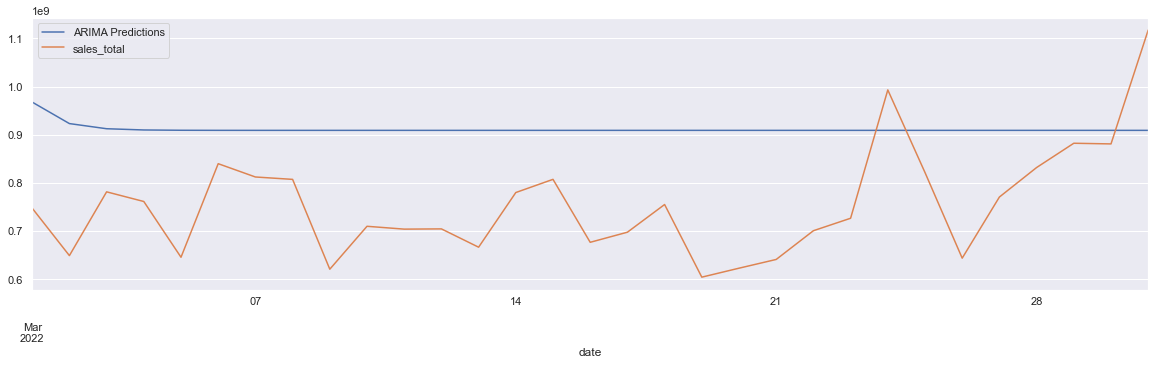

In [73]:
plt.figure(figsize = (20,5))
pred=res.predict(start='2022-03-01',end='2022-03-31').rename('ARIMA Predictions')
pred.plot(legend=True)
sales_valid['sales_total'].plot(legend=True)

C:\Users\ariel\AppData\Local\Temp/ipykernel_22548/2666341350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_init['res_ar_1_i_1_ma_1'] = results_ar_1_1_1_ma_1.resid


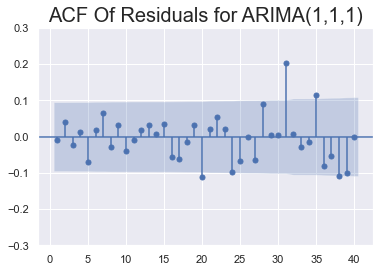

In [74]:
sales_init['res_ar_1_i_1_ma_1'] = results_ar_1_1_1_ma_1.resid
sgt.plot_acf(sales_init.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.ylim(-0.3,0.3)
plt.show()

C:\Users\ariel\AppData\Local\Temp/ipykernel_22548/3498674167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_init['results'] = results_ar_1_1_1_ma_1.predict()


<AxesSubplot:xlabel='date'>

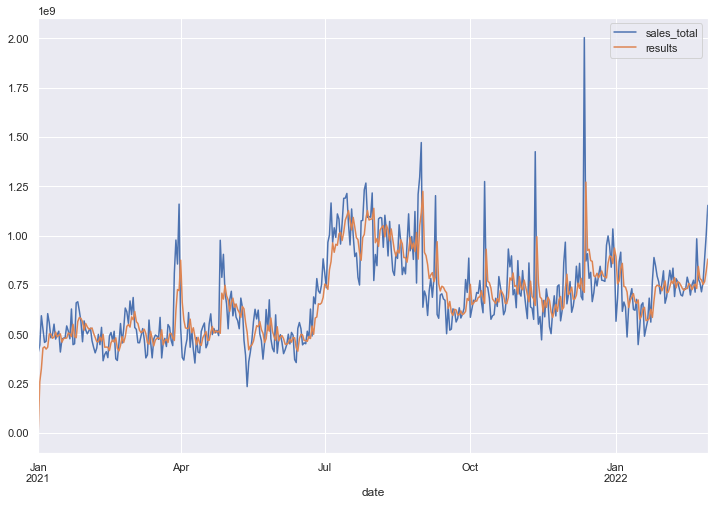

In [75]:
sales_init['results'] = results_ar_1_1_1_ma_1.predict()
sales_init[['sales_total','results']].plot(figsize=(12,8))

In [76]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(sales_init['sales_total'], trace=True,max_q = 10, max_p = 10, max_d = 4,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17122.447, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17240.082, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17174.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17129.046, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17238.129, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17123.044, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17122.695, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17124.465, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17124.495, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17121.098, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17122.066, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17157.901, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17118.502, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17127.282, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0

<AxesSubplot:xlabel='date'>

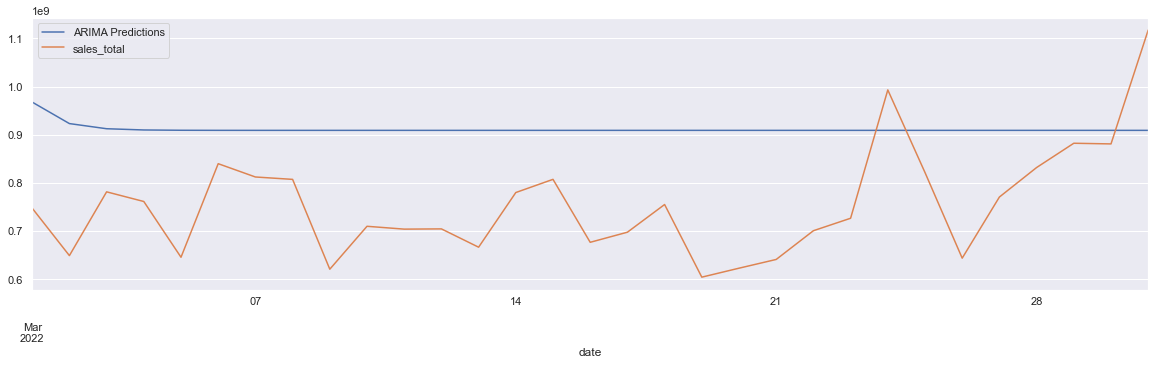

In [77]:
plt.figure(figsize = (20,5))
pred=results_ar_1_1_1_ma_1.predict(start='2022-03-1',end='2022-03-31').rename('ARIMA Predictions')
pred.plot(legend=True)
sales_valid['sales_total'].plot(legend=True)

In [78]:
pred

2022-03-01    9.676594e+08
2022-03-02    9.230633e+08
2022-03-03    9.123626e+08
2022-03-04    9.097949e+08
2022-03-05    9.091788e+08
2022-03-06    9.090310e+08
2022-03-07    9.089955e+08
2022-03-08    9.089870e+08
2022-03-09    9.089850e+08
2022-03-10    9.089845e+08
2022-03-11    9.089844e+08
2022-03-12    9.089843e+08
2022-03-13    9.089843e+08
2022-03-14    9.089843e+08
2022-03-15    9.089843e+08
2022-03-16    9.089843e+08
2022-03-17    9.089843e+08
2022-03-18    9.089843e+08
2022-03-19    9.089843e+08
2022-03-20    9.089843e+08
2022-03-21    9.089843e+08
2022-03-22    9.089843e+08
2022-03-23    9.089843e+08
2022-03-24    9.089843e+08
2022-03-25    9.089843e+08
2022-03-26    9.089843e+08
2022-03-27    9.089843e+08
2022-03-28    9.089843e+08
2022-03-29    9.089843e+08
2022-03-30    9.089843e+08
2022-03-31    9.089843e+08
Freq: D, Name: ARIMA Predictions, dtype: float64

In [79]:
sales_valid.sales_total

date
2022-03-01     747274661
2022-03-02     648780165
2022-03-03     781247405
2022-03-04     761182402
2022-03-05     645367045
2022-03-06     839730955
2022-03-07     812108136
2022-03-08     807149435
2022-03-09     620534715
2022-03-10     709686228
2022-03-11     703778635
2022-03-12     704276403
2022-03-13     666245930
2022-03-14     779812822
2022-03-15     807196332
2022-03-16     676426620
2022-03-17     697394026
2022-03-18     754908564
2022-03-19     604030628
2022-03-20     622625362
2022-03-21     640791783
2022-03-22     700486049
2022-03-23     726385285
2022-03-24     992994017
2022-03-25     821363572
2022-03-26     643486113
2022-03-27     770474712
2022-03-28     831755420
2022-03-29     882196402
2022-03-30     880823307
2022-03-31    1117364150
Freq: D, Name: sales_total, dtype: int64

In [80]:
model_ar_1_i_1_ma_2 = ARIMA(sales_init.sales_total, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(sales_init.sales_total, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(sales_init.sales_total, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(sales_init.sales_total, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(sales_init.sales_total, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit()

C:\Users\ariel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ariel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:xlabel='date'>

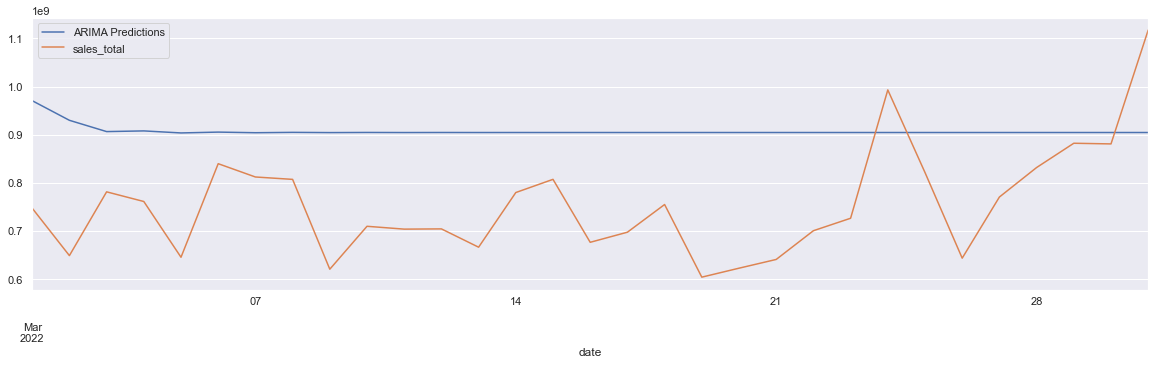

In [81]:
plt.figure(figsize = (20,5))
pred1=results_ar_3_i_1_ma_2.predict(start='2022-03-1',end='2022-03-31').rename('ARIMA Predictions')
pred1.plot(legend=True)
sales_valid['sales_total'].plot(legend=True)

# Prophet

In [82]:
def mape(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/ y_true)) *100

In [83]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [84]:
from prophet import Prophet

In [85]:
pdataset =pd.read_csv("Jan No Channel.csv")
pdataset.drop(columns = ['order_no','shipping_amount','shipping_discount_amount','qty'],inplace = True)
pdataset.rename(columns = {'order_date':'ds', 'sales_total':'y'}, inplace = True)
pdataset['ds'] = pd.to_datetime(pdataset['ds'], format = '%d/%m/%Y')
pdataset= pdataset.loc[:454]
pdataset

,ds,y
0,2021-01-01,407403204
1,2021-01-02,445345327
2,2021-01-03,594148762
3,2021-01-04,527649866
4,2021-01-05,458552555
...,...,...
450,2022-03-27,770474712
451,2022-03-28,831755420
452,2022-03-29,882196402
453,2022-03-30,880823307


In [86]:
pdataset[pdataset['ds'] == '2022-03-31']

,ds,y
454,2022-03-31,1117364150


In [87]:
p_train = pdataset.loc[:423]
p_test = pdataset.loc[424:]

In [88]:
m = Prophet()
#m.add_seasonality(name='weekly', fourier_order=3, period=7)
model_prophet = m.fit(p_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [89]:
future = m.make_future_dataframe(periods=31,freq='D')
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,4.273227e+08,1.601266e+08,6.243210e+08,4.273227e+08,4.273227e+08,-3.425948e+07,-3.425948e+07,-3.425948e+07,-3.425948e+07,-3.425948e+07,-3.425948e+07,0.0,0.0,0.0,3.930633e+08
1,2021-01-02,4.288169e+08,1.221768e+08,5.832837e+08,4.288169e+08,4.288169e+08,-7.637644e+07,-7.637644e+07,-7.637644e+07,-7.637644e+07,-7.637644e+07,-7.637644e+07,0.0,0.0,0.0,3.524405e+08
2,2021-01-03,4.303111e+08,2.214817e+08,6.803273e+08,4.303111e+08,4.303111e+08,1.314017e+07,1.314017e+07,1.314017e+07,1.314017e+07,1.314017e+07,1.314017e+07,0.0,0.0,0.0,4.434512e+08
3,2021-01-04,4.318052e+08,2.397717e+08,7.114816e+08,4.318052e+08,4.318052e+08,4.265077e+07,4.265077e+07,4.265077e+07,4.265077e+07,4.265077e+07,4.265077e+07,0.0,0.0,0.0,4.744560e+08
4,2021-01-05,4.332994e+08,2.369349e+08,6.886122e+08,4.332994e+08,4.332994e+08,3.866263e+07,3.866263e+07,3.866263e+07,3.866263e+07,3.866263e+07,3.866263e+07,0.0,0.0,0.0,4.719620e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2022-03-27,7.148687e+08,5.004236e+08,9.458989e+08,7.107854e+08,7.184516e+08,1.314017e+07,1.314017e+07,1.314017e+07,1.314017e+07,1.314017e+07,1.314017e+07,0.0,0.0,0.0,7.280089e+08
451,2022-03-28,7.144655e+08,5.444816e+08,9.855633e+08,7.100720e+08,7.182194e+08,4.265077e+07,4.265077e+07,4.265077e+07,4.265077e+07,4.265077e+07,4.265077e+07,0.0,0.0,0.0,7.571163e+08
452,2022-03-29,7.140624e+08,5.239398e+08,9.563352e+08,7.094562e+08,7.179668e+08,3.866263e+07,3.866263e+07,3.866263e+07,3.866263e+07,3.866263e+07,3.866263e+07,0.0,0.0,0.0,7.527250e+08
453,2022-03-30,7.136592e+08,5.003387e+08,9.509390e+08,7.087891e+08,7.177901e+08,5.339164e+06,5.339164e+06,5.339164e+06,5.339164e+06,5.339164e+06,5.339164e+06,0.0,0.0,0.0,7.189984e+08


In [90]:
ab = pd.Series(forecast.ds).loc[424:]
ba = pd.Series(forecast.yhat).loc[424:]
d = {'ds' : ab, 'ba' : ba}
prophet_m = pd.DataFrame(data = d)
prophet_m

,ds,ba
424,2022-03-01,7.640138e+08
425,2022-03-02,7.302872e+08
426,2022-03-03,7.353880e+08
427,2022-03-04,6.898822e+08
428,2022-03-05,6.473621e+08
429,2022-03-06,7.364755e+08
430,2022-03-07,7.655829e+08
431,2022-03-08,7.611916e+08
432,2022-03-09,7.274650e+08
433,2022-03-10,7.325658e+08


In [91]:
from sklearn.metrics import mean_squared_error

In [92]:
mean_squared_error(prophet_m.ba, p_test.y, squared = False) #RMSE

111616108.49024512

In [93]:
mape(p_train.y, forecast.yhat.loc[:423]) #Train #MAPE

19.788911212892398

In [94]:
mape(p_test.y, prophet_m.ba) #Test #MAPE

9.769027133405453

In [95]:
# Training Difference Sum
#print('Sum: ',sum(abs(p_train.y - forecast.yhat.loc[:423]))) 
print('MAE: ', np.mean(abs(p_train.y - forecast.yhat.loc[:423])))

MAE:  131385530.24446426


In [96]:
# Testing Difference Sum
#print('Sum: ',sum(abs(p_test.y - prophet_m.ba))) 
print('MAE: ', np.mean(abs(p_test.y - prophet_m.ba)))

MAE:  78737744.68799502


<AxesSubplot:>

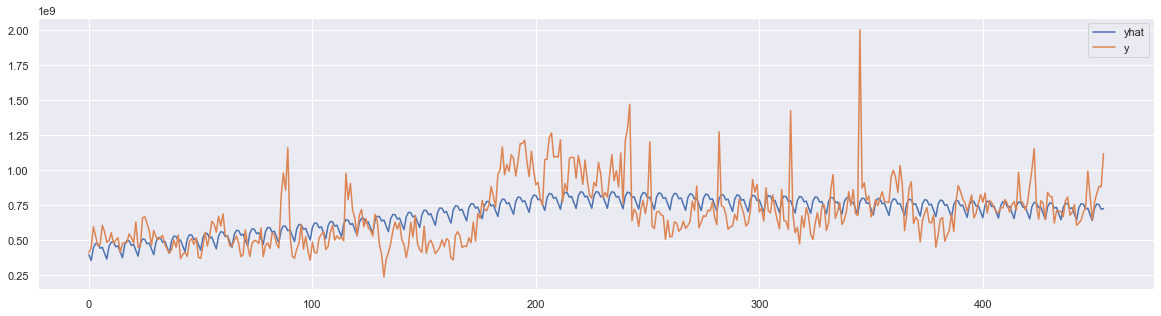

In [97]:
plt.figure(figsize = (20,5))
forecast.yhat.plot(legend = True)
pdataset.y.plot(legend = True)

Text(0.5, 1.0, 'Prophet BaseLine')

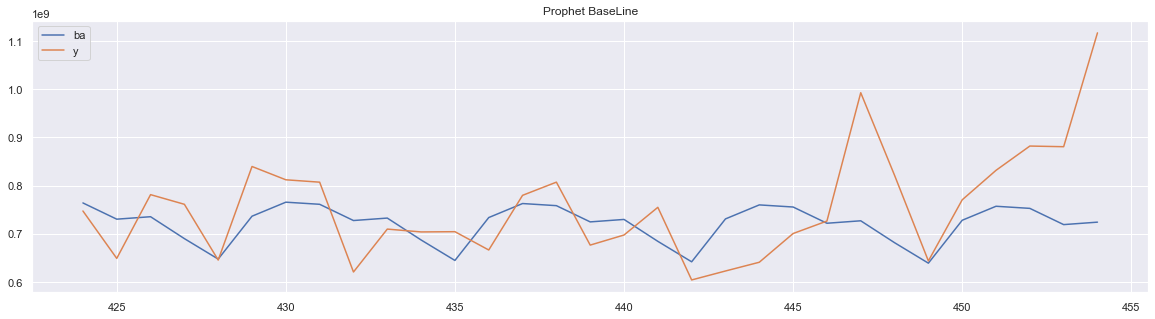

In [98]:
plt.figure(figsize = (20,5))
prophet_m.ba.plot(legend = True)
p_test.y.plot(legend = True)
plt.title('Prophet BaseLine')

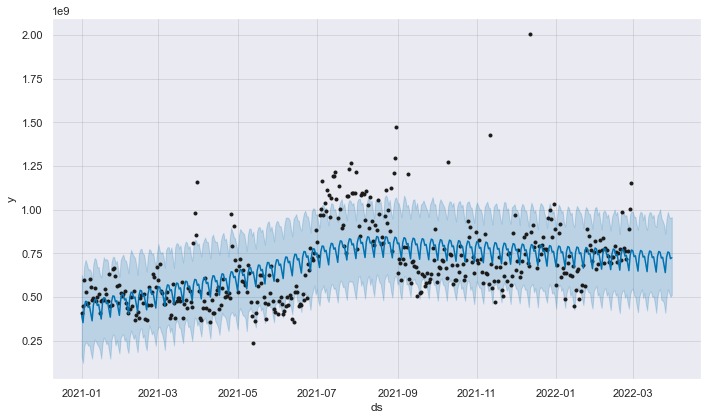

In [99]:
plot1 = model_prophet.plot(forecast)

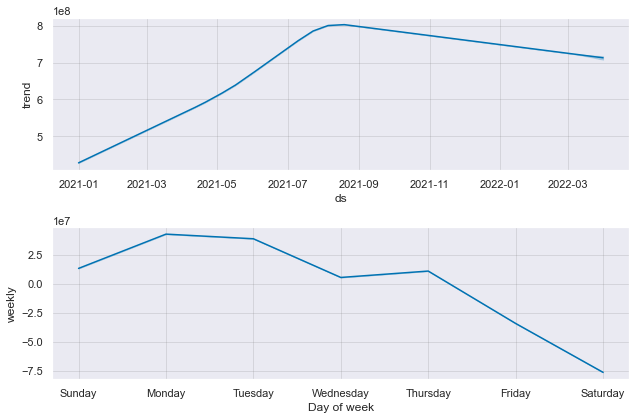

In [100]:
plt2 = model_prophet.plot_components(forecast)

## Tranform Data Sales

### Box Cox

In [101]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox


In [102]:
bcp = pdataset.copy()
bcp['y'], lambda_f = boxcox(bcp['y'])
b_train = bcp.loc[:423]
b_test = bcp.loc[424:]

In [103]:
mb = Prophet()
mb.add_seasonality(name='weekly', fourier_order=3, period=7)
mb.fit(b_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [104]:
futureb = mb.make_future_dataframe(periods=31,freq='D')
forecastb = mb.predict(futureb)
forecastb

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,5.169655,5.163605,5.172998,5.169655,5.169655,-0.000902,-0.000902,-0.000902,-0.000902,-0.000902,-0.000902,0.0,0.0,0.0,5.168753
1,2021-01-02,5.169724,5.162631,5.172028,5.169724,5.169724,-0.002543,-0.002543,-0.002543,-0.002543,-0.002543,-0.002543,0.0,0.0,0.0,5.167181
2,2021-01-03,5.169792,5.164759,5.174509,5.169792,5.169792,-0.000050,-0.000050,-0.000050,-0.000050,-0.000050,-0.000050,0.0,0.0,0.0,5.169742
3,2021-01-04,5.169861,5.166671,5.176139,5.169861,5.169861,0.001403,0.001403,0.001403,0.001403,0.001403,0.001403,0.0,0.0,0.0,5.171264
4,2021-01-05,5.169929,5.166872,5.176007,5.169929,5.169929,0.001384,0.001384,0.001384,0.001384,0.001384,0.001384,0.0,0.0,0.0,5.171314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2022-03-27,5.178714,5.166192,5.189470,5.167884,5.188319,-0.000050,-0.000050,-0.000050,-0.000050,-0.000050,-0.000050,0.0,0.0,0.0,5.178664
451,2022-03-28,5.178711,5.167905,5.191468,5.167153,5.189242,0.001403,0.001403,0.001403,0.001403,0.001403,0.001403,0.0,0.0,0.0,5.180114
452,2022-03-29,5.178707,5.167343,5.191699,5.166615,5.189819,0.001384,0.001384,0.001384,0.001384,0.001384,0.001384,0.0,0.0,0.0,5.180091
453,2022-03-30,5.178704,5.165959,5.191280,5.166015,5.190562,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.0,0.0,0.0,5.179052


In [105]:
forecastb['yhat'] = inv_boxcox(forecastb.yhat, lambda_f)
bcp['y'] = inv_boxcox(bcp.y, lambda_f)

Text(0.5, 1.0, 'Prophet BoxCox')

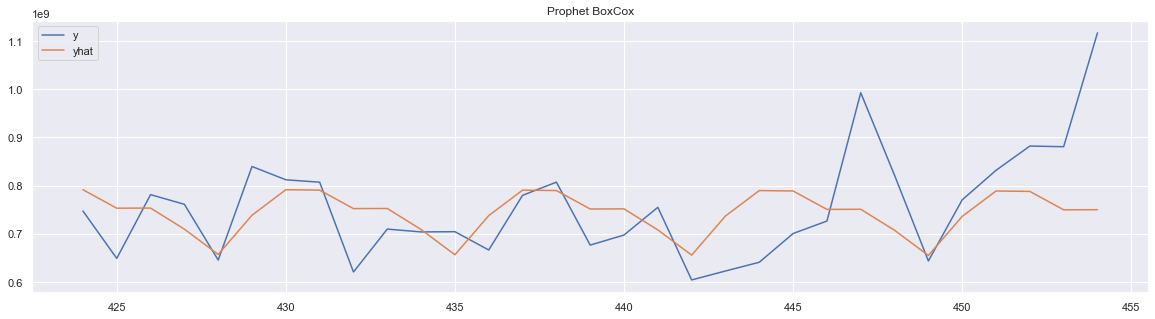

In [106]:
plt.figure(figsize = (20,5))
bcp['y'].loc[424:].plot(legend = True)
forecastb['yhat'].loc[424:].plot(legend = True)
plt.title('Prophet BoxCox')

Text(0.5, 1.0, 'Prophet BoxCox')

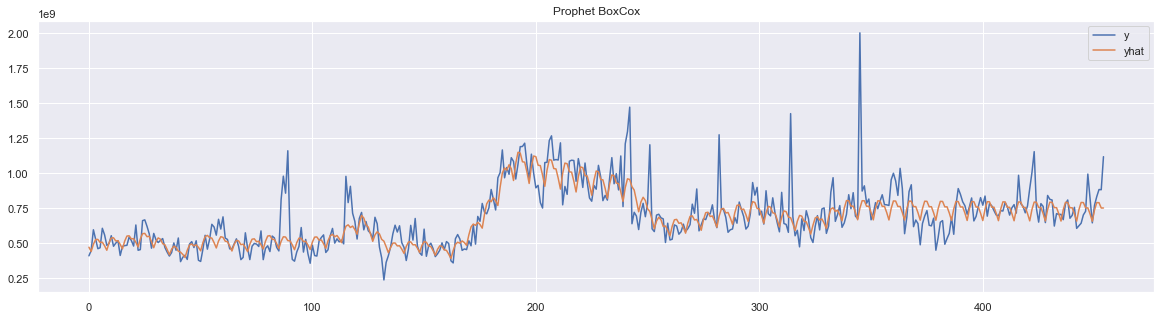

In [107]:
plt.figure(figsize = (20,5))
bcp['y'].plot(legend = True)
forecastb['yhat'].plot(legend = True)
plt.title('Prophet BoxCox')

In [108]:
mean_squared_error(bcp['y'].loc[424:], forecastb['yhat'].loc[424:], squared = False) #RMSE

105841064.58855261

In [109]:
mape(bcp['y'].loc[424:], forecastb['yhat'].loc[424:]) # Testing #MAPE

9.649593464275247

In [110]:
mape(bcp['y'].loc[:423], forecastb['yhat'].loc[:423]) #Training #MAPE

12.190855654590079

In [111]:
# Training Difference
#print('Sum: ',sum(abs(bcp['y'].loc[:423] - forecastb['yhat'].loc[:423]))) 
print('MAE: ', np.mean(abs(bcp['y'].loc[:423] - forecastb['yhat'].loc[:423])))

MAE:  86166800.68358067


In [112]:
# Testing Difference
#print('Sum: ',sum(abs(bcp['y'].loc[424:] -  forecastb['yhat'].loc[424:]))) 
print('MAE: ', np.mean(abs(bcp['y'].loc[424:] -  forecastb['yhat'].loc[424:])))

MAE:  75694393.11697327


### Add Regressor

In [113]:
prdataset =pd.read_csv("Jan No Channel.csv")
prdataset.rename(columns = {'order_date':'ds', 'sales_total':'y'}, inplace = True)
prdataset['ds'] = pd.to_datetime(prdataset['ds'], format = '%d/%m/%Y')
prdataset= prdataset.loc[:454]
prdataset

,ds,y,order_no,shipping_amount,shipping_discount_amount,qty
0,2021-01-01,407403204,633,51411999.96,35233000.90,1770
1,2021-01-02,445345327,738,50072999.99,35661000.08,1965
2,2021-01-03,594148762,801,72007000.19,51539000.09,2260
3,2021-01-04,527649866,761,66817000.01,52830000.89,1937
4,2021-01-05,458552555,718,48697000.06,36431000.18,2225
...,...,...,...,...,...,...
450,2022-03-27,770474712,1013,36908000.03,22512000.04,2628
451,2022-03-28,831755420,994,39330000.44,24969000.49,2799
452,2022-03-29,882196402,1081,38926499.22,22801248.38,3232
453,2022-03-30,880823307,1059,41502999.84,25574999.59,3211


In [114]:
pr_train = prdataset.loc[:423]
pr_test = prdataset.loc[424:]

In [115]:
pr_train

,ds,y,order_no,shipping_amount,shipping_discount_amount,qty
0,2021-01-01,407403204,633,51411999.96,35233000.90,1770
1,2021-01-02,445345327,738,50072999.99,35661000.08,1965
2,2021-01-03,594148762,801,72007000.19,51539000.09,2260
3,2021-01-04,527649866,761,66817000.01,52830000.89,1937
4,2021-01-05,458552555,718,48697000.06,36431000.18,2225
...,...,...,...,...,...,...
419,2022-02-24,715275934,1052,33317999.84,19805499.80,2643
420,2022-02-25,764748022,1091,32575499.99,19475499.99,2793
421,2022-02-26,888741909,1149,38002500.29,25455000.20,2884
422,2022-02-27,1004532793,1308,50166499.99,28433000.05,3057


In [116]:
mr = Prophet()
mr.add_seasonality(name='weekly', fourier_order=3, period=7)
mr.add_regressor('order_no')
mr.fit(pr_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [117]:
futurer = mr.make_future_dataframe(periods=31,freq='D')
futurer['order_no'] = prdataset['order_no']
forecastr = mr.predict(futurer)
forecastr

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,order_no,order_no_lower,order_no_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.758462e+08,3.530349e+08,5.948051e+08,6.758462e+08,6.758462e+08,-2.038003e+08,-2.038003e+08,-2.038003e+08,-2.177042e+08,...,-2.177042e+08,-2.177042e+08,-2.177042e+08,1.390385e+07,1.390385e+07,1.390385e+07,0.0,0.0,0.0,4.720458e+08
1,2021-01-02,6.754700e+08,3.905913e+08,6.280212e+08,6.754700e+08,6.754700e+08,-1.654591e+08,-1.654591e+08,-1.654591e+08,-1.350176e+08,...,-1.350176e+08,-1.350176e+08,-1.350176e+08,-3.044148e+07,-3.044148e+07,-3.044148e+07,0.0,0.0,0.0,5.100109e+08
2,2021-01-03,6.750938e+08,4.450864e+08,6.962651e+08,6.750938e+08,6.750938e+08,-1.021583e+08,-1.021583e+08,-1.021583e+08,-8.540565e+07,...,-8.540565e+07,-8.540565e+07,-8.540565e+07,-1.675265e+07,-1.675265e+07,-1.675265e+07,0.0,0.0,0.0,5.729355e+08
3,2021-01-04,6.747176e+08,4.656217e+08,6.906756e+08,6.747176e+08,6.747176e+08,-9.956759e+07,-9.956759e+07,-9.956759e+07,-1.169053e+08,...,-1.169053e+08,-1.169053e+08,-1.169053e+08,1.733771e+07,1.733771e+07,1.733771e+07,0.0,0.0,0.0,5.751500e+08
4,2021-01-05,6.743414e+08,3.982208e+08,6.249493e+08,6.743414e+08,6.743414e+08,-1.596643e+08,-1.596643e+08,-1.596643e+08,-1.507674e+08,...,-1.507674e+08,-1.507674e+08,-1.507674e+08,-8.896832e+06,-8.896832e+06,-8.896832e+06,0.0,0.0,0.0,5.146772e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2022-03-27,6.413371e+08,5.960875e+08,8.197684e+08,6.386519e+08,6.443430e+08,6.478984e+07,6.478984e+07,6.478984e+07,8.154249e+07,...,8.154249e+07,8.154249e+07,8.154249e+07,-1.675265e+07,-1.675265e+07,-1.675265e+07,0.0,0.0,0.0,7.061269e+08
451,2022-03-28,6.405728e+08,6.108178e+08,8.411432e+08,6.377009e+08,6.438069e+08,8.391786e+07,8.391786e+07,8.391786e+07,6.658015e+07,...,6.658015e+07,6.658015e+07,6.658015e+07,1.733771e+07,1.733771e+07,1.733771e+07,0.0,0.0,0.0,7.244907e+08
452,2022-03-29,6.398085e+08,6.397352e+08,8.850173e+08,6.367462e+08,6.432909e+08,1.261951e+08,1.261951e+08,1.261951e+08,1.350919e+08,...,1.350919e+08,1.350919e+08,1.350919e+08,-8.896832e+06,-8.896832e+06,-8.896832e+06,0.0,0.0,0.0,7.660035e+08
453,2022-03-30,6.390442e+08,6.581524e+08,8.961751e+08,6.357842e+08,6.427417e+08,1.332483e+08,1.332483e+08,1.332483e+08,1.177671e+08,...,1.177671e+08,1.177671e+08,1.177671e+08,1.548120e+07,1.548120e+07,1.548120e+07,0.0,0.0,0.0,7.722925e+08


Text(0.5, 1.0, 'Prophet Regressor (order_no)')

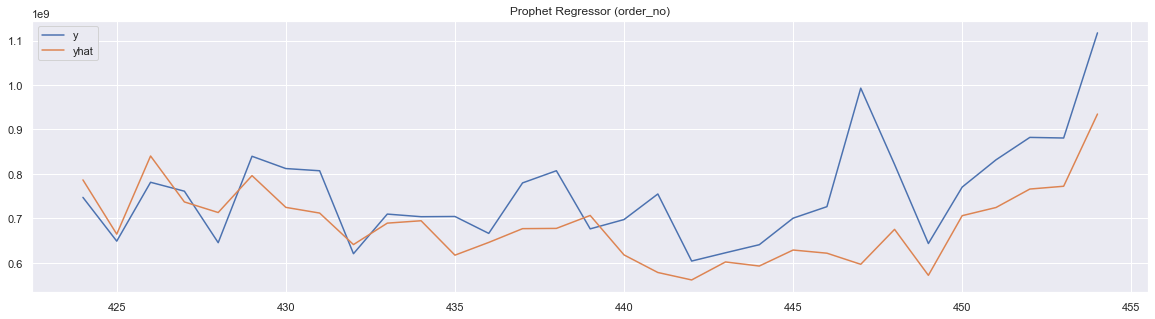

In [118]:
plt.figure(figsize = (20,5))
prdataset['y'].loc[424:].plot(legend = True)
forecastr['yhat'].loc[424:].plot(legend = True)
plt.title('Prophet Regressor (order_no)')

Text(0.5, 1.0, 'Prophet Regressor (order_no)')

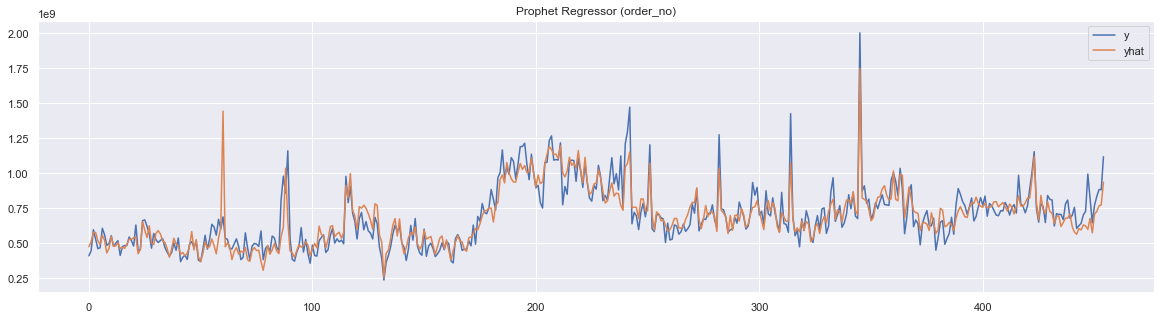

In [119]:
plt.figure(figsize = (20,5))
prdataset['y'].plot(legend = True)
forecastr['yhat'].plot(legend = True)
plt.title('Prophet Regressor (order_no)')

In [120]:
mean_squared_error(prdataset['y'].loc[424:], forecastr['yhat'].loc[424:], squared = False) #RMSE

111034150.9471451

In [121]:
mape(prdataset['y'].loc[424:], forecastr['yhat'].loc[424:]) # Testing #MAPE

10.40133486464487

In [122]:
mape(prdataset['y'].loc[:423], forecastr['yhat'].loc[:423]) # Training #MAPE

9.321494597994139

In [123]:
# Training Difference
#print('Sum: ',sum(abs(prdataset['y'].loc[:423] - forecastr['yhat'].loc[:423]))) 
print('MAE: ', np.mean(abs(prdataset['y'].loc[:423] - forecastr['yhat'].loc[:423])))

MAE:  63263020.46189959


In [124]:
# Testing Difference
#print('Sum: ',sum(abs(prdataset['y'].loc[424:]- forecastr['yhat'].loc[424:]))) 
print('MAE: ', np.mean(abs(prdataset['y'].loc[424:]- forecastr['yhat'].loc[424:])))

MAE:  83508448.592023


- Prediksi - Aktual (Absolut) DONE
- Train smp april -- Tes Mei DONE
- Liat Code Lain
- Coba Regressor Lain (Traffic dkk.) -- Imputasi Null / 0

# Train smp April -- Tes Mei

In [125]:
data_smp_mei = pd.read_csv('Sales smp Mei.csv')
data_smp_mei.drop(columns = ['order_no','shipping_amount','shipping_discount_amount','qty'],inplace = True)
data_smp_mei.rename(columns = {'order_date':'ds', 'sales_total':'y'}, inplace = True)
data_smp_mei['ds'] = pd.to_datetime(data_smp_mei['ds'], format = '%d/%m/%Y')
data_smp_mei = data_smp_mei.loc[:515]
data_smp_mei

,ds,y
0,2021-01-01,407403204
1,2021-01-02,445345327
2,2021-01-03,594148762
3,2021-01-04,527649866
4,2021-01-05,458552555
...,...,...
511,2022-05-27,860972777
512,2022-05-28,598901014
513,2022-05-29,706611951
514,2022-05-30,849215021


In [126]:
data_smp_mei[data_smp_mei['ds'] == '2022-04-30']

,ds,y
484,2022-04-30,770137844


In [127]:
mei_train = data_smp_mei.loc[:484]
mei_test = data_smp_mei.loc[485:]

In [128]:
mei = Prophet()
mei.add_seasonality(name='weekly', fourier_order=3, period=7)
mei_prophet = mei.fit(mei_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [129]:
mei_f = mei.make_future_dataframe(periods=31,freq='D')
forecast_mei = mei.predict(mei_f)
forecast_mei

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,4.297817e+08,1.736798e+08,6.206897e+08,4.297817e+08,4.297817e+08,-3.260765e+07,-3.260765e+07,-3.260765e+07,-3.260765e+07,-3.260765e+07,-3.260765e+07,0.0,0.0,0.0,3.971740e+08
1,2021-01-02,4.312431e+08,1.322524e+08,5.701548e+08,4.312431e+08,4.312431e+08,-7.325101e+07,-7.325101e+07,-7.325101e+07,-7.325101e+07,-7.325101e+07,-7.325101e+07,0.0,0.0,0.0,3.579921e+08
2,2021-01-03,4.327046e+08,2.156235e+08,6.616884e+08,4.327046e+08,4.327046e+08,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,0.0,0.0,0.0,4.390022e+08
3,2021-01-04,4.341660e+08,2.566400e+08,6.777951e+08,4.341660e+08,4.341660e+08,4.220735e+07,4.220735e+07,4.220735e+07,4.220735e+07,4.220735e+07,4.220735e+07,0.0,0.0,0.0,4.763734e+08
4,2021-01-05,4.356274e+08,2.651959e+08,7.064507e+08,4.356274e+08,4.356274e+08,3.967000e+07,3.967000e+07,3.967000e+07,3.967000e+07,3.967000e+07,3.967000e+07,0.0,0.0,0.0,4.752974e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2022-05-27,7.983309e+08,5.402323e+08,9.762594e+08,7.947487e+08,8.019592e+08,-3.260765e+07,-3.260765e+07,-3.260765e+07,-3.260765e+07,-3.260765e+07,-3.260765e+07,0.0,0.0,0.0,7.657232e+08
512,2022-05-28,7.986023e+08,4.917211e+08,9.512452e+08,7.947429e+08,8.025546e+08,-7.325101e+07,-7.325101e+07,-7.325101e+07,-7.325101e+07,-7.325101e+07,-7.325101e+07,0.0,0.0,0.0,7.253513e+08
513,2022-05-29,7.988737e+08,5.817929e+08,1.034890e+09,7.947701e+08,8.031251e+08,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,0.0,0.0,0.0,8.051713e+08
514,2022-05-30,7.991451e+08,6.129116e+08,1.065807e+09,7.948329e+08,8.037008e+08,4.220735e+07,4.220735e+07,4.220735e+07,4.220735e+07,4.220735e+07,4.220735e+07,0.0,0.0,0.0,8.413524e+08


In [130]:
forecast_mei[forecast_mei['ds'] == '2022-05-01']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
485,2022-05-01,7.912747e+08,5.881229e+08,1.018672e+09,7.912747e+08,7.912747e+08,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,6.297636e+06,0.0,0.0,0.0,7.975723e+08


In [131]:
mean_squared_error(mei_test['y'], forecast_mei['yhat'].loc[485:], squared = False) #RMSE

172345656.54385397

In [132]:
mape(mei_test['y'], forecast_mei['yhat'].loc[485:]) #Testing #MAPE

23.5120569028573

In [133]:
mape(mei_train['y'],forecast_mei['yhat'].loc[:484]) #Training #MAPE

18.612269966763087

In [134]:
# Training Difference Sum
#print('Sum: ',sum(abs(mei_train['y'] - forecast_mei['yhat'].loc[:484]))) 
print('MAE: ', np.mean(abs(mei_train['y'] - forecast_mei['yhat'].loc[:484])))

MAE:  125522798.03019094


In [135]:
# Testing Difference Sum
#print('Sum: ',sum(abs(mei_test['y']-  forecast_mei['yhat'].loc[485:]))) 
print('MAE: ', np.mean(abs(mei_test['y']-  forecast_mei['yhat'].loc[485:])))

MAE:  133772607.53971349


<AxesSubplot:>

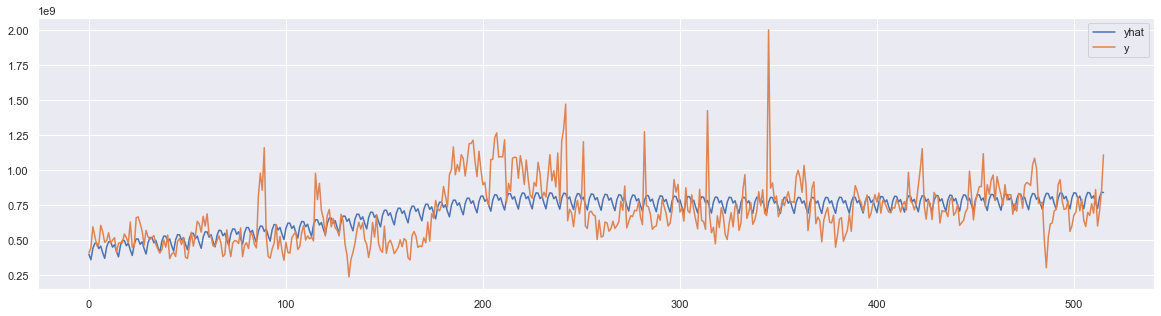

In [136]:
plt.figure(figsize = (20,5))
forecast_mei.yhat.plot(legend = True)
data_smp_mei.y.plot(legend = True)

<AxesSubplot:>

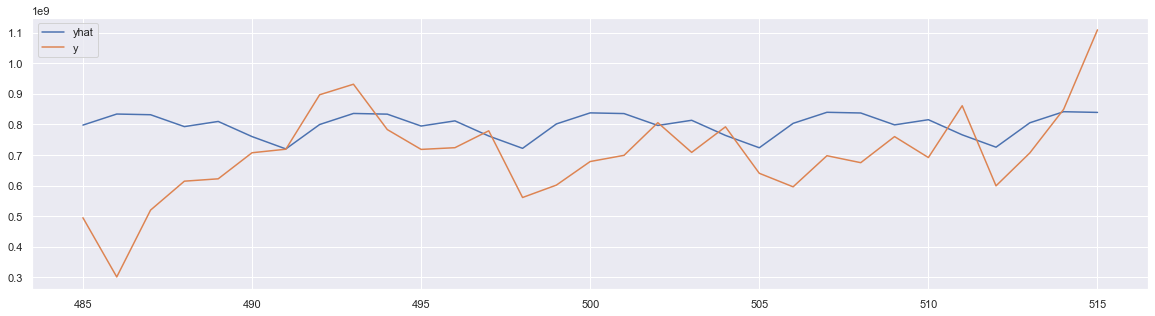

In [137]:
plt.figure(figsize = (20,5))
forecast_mei.loc[485:].yhat.plot(legend = True)
data_smp_mei.loc[485:].y.plot(legend = True)

## Box-Cox Mei

In [138]:
box_mei = data_smp_mei.copy()
box_mei['y'], lambda_mei = boxcox(box_mei['y'])
box_mei_train = box_mei.loc[:484]
box_mei_test = box_mei.loc[485:]

In [139]:
box_mei_prophet = Prophet()
box_mei_prophet.add_seasonality(name='weekly', fourier_order=3, period=7)
box_mei_prophet.fit(box_mei_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [140]:
box_mei_f = mei.make_future_dataframe(periods=31,freq='D')
forecast_box_mei = box_mei_prophet.predict(box_mei_f)
forecast_box_mei

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,16.349344,16.168889,16.460054,16.349344,16.349344,-0.026536,-0.026536,-0.026536,-0.026536,-0.026536,-0.026536,0.0,0.0,0.0,16.322808
1,2021-01-02,16.349061,16.124903,16.436937,16.349061,16.349061,-0.072627,-0.072627,-0.072627,-0.072627,-0.072627,-0.072627,0.0,0.0,0.0,16.276435
2,2021-01-03,16.348778,16.193489,16.487638,16.348778,16.348778,-0.003585,-0.003585,-0.003585,-0.003585,-0.003585,-0.003585,0.0,0.0,0.0,16.345193
3,2021-01-04,16.348495,16.248825,16.546251,16.348495,16.348495,0.041556,0.041556,0.041556,0.041556,0.041556,0.041556,0.0,0.0,0.0,16.390052
4,2021-01-05,16.348212,16.239529,16.543185,16.348212,16.348212,0.040984,0.040984,0.040984,0.040984,0.040984,0.040984,0.0,0.0,0.0,16.389197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2022-05-27,16.736237,16.546993,16.873112,16.678306,16.795588,-0.026536,-0.026536,-0.026536,-0.026536,-0.026536,-0.026536,0.0,0.0,0.0,16.709700
512,2022-05-28,16.737592,16.503805,16.825211,16.675073,16.799622,-0.072627,-0.072627,-0.072627,-0.072627,-0.072627,-0.072627,0.0,0.0,0.0,16.664965
513,2022-05-29,16.738946,16.568346,16.898743,16.671489,16.806015,-0.003585,-0.003585,-0.003585,-0.003585,-0.003585,-0.003585,0.0,0.0,0.0,16.735361
514,2022-05-30,16.740301,16.613250,16.947756,16.668459,16.813106,0.041556,0.041556,0.041556,0.041556,0.041556,0.041556,0.0,0.0,0.0,16.781858


In [141]:
forecast_box_mei['yhat'] = inv_boxcox(forecast_box_mei.yhat, lambda_mei)
box_mei['y'] = inv_boxcox(box_mei.y, lambda_mei)

Text(0.5, 1.0, 'Prophet BoxCox Mei Test')

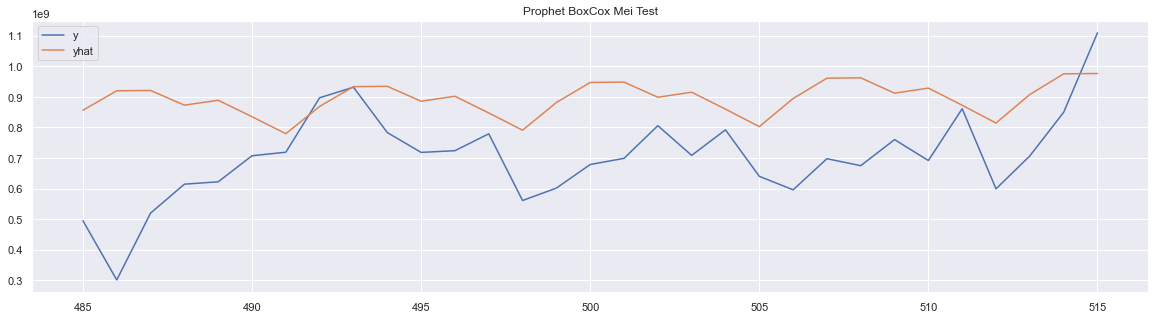

In [142]:
plt.figure(figsize = (20,5))
box_mei['y'].loc[485:].plot(legend = True)
forecast_box_mei['yhat'].loc[485:].plot(legend = True)
plt.title('Prophet BoxCox Mei Test')

Text(0.5, 1.0, 'Prophet BoxCox Mei Test')

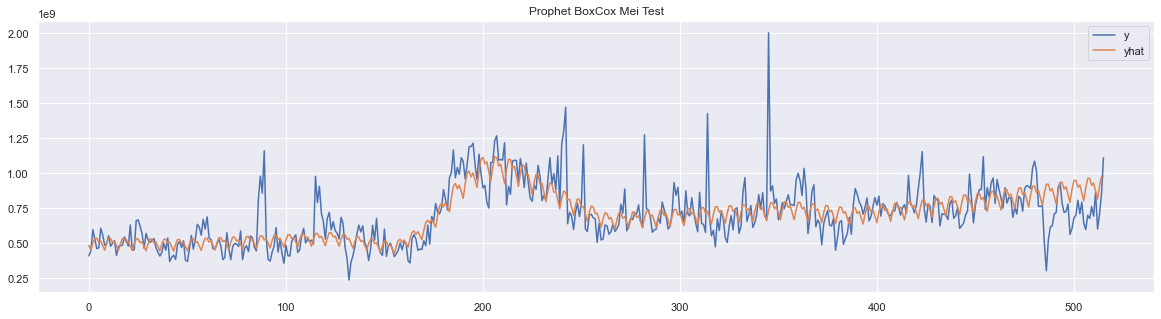

In [143]:
plt.figure(figsize = (20,5))
box_mei['y'].plot(legend = True)
forecast_box_mei['yhat'].plot(legend = True)
plt.title('Prophet BoxCox Mei Test')

In [144]:
mean_squared_error(box_mei_train['y'], forecast_box_mei['yhat'].loc[:484], squared = False) #RMSE

139548980.79435256

In [145]:
mape(box_mei_train['y'], forecast_box_mei['yhat'].loc[:484]) #Train #MAPE

12.943048697287926

In [146]:
mape(box_mei_test['y'], forecast_box_mei['yhat'].loc[485:]) #Test #MAPE

34.23663084880193

In [147]:
# Training Difference
#print('Sum: ',sum(abs(box_mei_train['y']- forecast_box_mei['yhat'].loc[:484]))) 
print('MAE: ', np.mean(abs(box_mei_train['y']- forecast_box_mei['yhat'].loc[:484])))

MAE:  91684847.37809476


In [148]:
# Testing Difference
#print('Sum: ',sum(abs(box_mei_test['y']- forecast_box_mei['yhat'].loc[485:]))) 
print('MAE: ', np.mean(abs(box_mei_test['y']- forecast_box_mei['yhat'].loc[485:])))

MAE:  199076126.4695022


## Add Regressor Mei

In [149]:
data_smp_mei_reg = pd.read_csv('Sales smp Mei.csv')
data_smp_mei_reg.rename(columns = {'order_date':'ds', 'sales_total':'y'}, inplace = True)
data_smp_mei_reg['ds'] = pd.to_datetime(data_smp_mei['ds'], format = '%d/%m/%Y')
data_smp_mei_reg = data_smp_mei_reg.loc[:515]
data_smp_mei_reg

,ds,y,order_no,shipping_amount,shipping_discount_amount,qty
0,2021-01-01,407403204,633,51411999.96,35233000.90,1770
1,2021-01-02,445345327,738,50072999.99,35661000.08,1965
2,2021-01-03,594148762,801,72007000.19,51539000.09,2260
3,2021-01-04,527649866,761,66817000.01,52830000.89,1937
4,2021-01-05,458552555,718,48697000.06,36431000.18,2225
...,...,...,...,...,...,...
511,2022-05-27,860972777,889,32462750.13,18900500.21,2594
512,2022-05-28,598901014,831,25883500.06,17664000.05,2208
513,2022-05-29,706611951,975,31184999.54,20997499.52,2779
514,2022-05-30,849215021,1006,35479999.97,21869749.96,2984


In [150]:
data_smp_mei_reg_train = data_smp_mei_reg.loc[:484]
data_smp_mei_reg_test = data_smp_mei_reg.loc[485:]

In [151]:
dsmr = Prophet()
dsmr.add_seasonality(name='weekly', fourier_order=3, period=7)
dsmr.add_regressor('order_no')
dsmr.fit(data_smp_mei_reg_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [152]:
dsmr_future = dsmr.make_future_dataframe(periods=31,freq='D')
dsmr_future['order_no'] = data_smp_mei_reg['order_no']
dsmr_forecast = dsmr.predict(dsmr_future)
dsmr_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,order_no,order_no_lower,order_no_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.760646e+08,3.628761e+08,5.878199e+08,6.760646e+08,6.760646e+08,-2.062118e+08,-2.062118e+08,-2.062118e+08,-2.211974e+08,...,-2.211974e+08,-2.211974e+08,-2.211974e+08,1.498561e+07,1.498561e+07,1.498561e+07,0.0,0.0,0.0,4.698528e+08
1,2021-01-02,6.757580e+08,3.815316e+08,6.239010e+08,6.757580e+08,6.757580e+08,-1.708363e+08,-1.708363e+08,-1.708363e+08,-1.397772e+08,...,-1.397772e+08,-1.397772e+08,-1.397772e+08,-3.105903e+07,-3.105903e+07,-3.105903e+07,0.0,0.0,0.0,5.049217e+08
2,2021-01-03,6.754514e+08,4.446706e+08,6.832252e+08,6.754514e+08,6.754514e+08,-1.132258e+08,-1.132258e+08,-1.132258e+08,-9.092516e+07,...,-9.092516e+07,-9.092516e+07,-9.092516e+07,-2.230066e+07,-2.230066e+07,-2.230066e+07,0.0,0.0,0.0,5.622256e+08
3,2021-01-04,6.751448e+08,4.505454e+08,6.869640e+08,6.751448e+08,6.751448e+08,-1.038133e+08,-1.038133e+08,-1.038133e+08,-1.219424e+08,...,-1.219424e+08,-1.219424e+08,-1.219424e+08,1.812903e+07,1.812903e+07,1.812903e+07,0.0,0.0,0.0,5.713314e+08
4,2021-01-05,6.748382e+08,3.986099e+08,6.291097e+08,6.748382e+08,6.748382e+08,-1.608016e+08,-1.608016e+08,-1.608016e+08,-1.552858e+08,...,-1.552858e+08,-1.552858e+08,-1.552858e+08,-5.515715e+06,-5.515715e+06,-5.515715e+06,0.0,0.0,0.0,5.140366e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2022-05-27,7.661648e+08,6.366012e+08,8.781311e+08,7.628130e+08,7.693031e+08,-7.701708e+06,-7.701708e+06,-7.701708e+06,-2.268732e+07,...,-2.268732e+07,-2.268732e+07,-2.268732e+07,1.498561e+07,1.498561e+07,1.498561e+07,0.0,0.0,0.0,7.584631e+08
512,2022-05-28,7.666060e+08,5.495898e+08,7.874936e+08,7.629647e+08,7.699847e+08,-9.872129e+07,-9.872129e+07,-9.872129e+07,-6.766226e+07,...,-6.766226e+07,-6.766226e+07,-6.766226e+07,-3.105903e+07,-3.105903e+07,-3.105903e+07,0.0,0.0,0.0,6.678847e+08
513,2022-05-29,7.670472e+08,6.805815e+08,9.049238e+08,7.632649e+08,7.706557e+08,2.169899e+07,2.169899e+07,2.169899e+07,4.399966e+07,...,4.399966e+07,4.399966e+07,4.399966e+07,-2.230066e+07,-2.230066e+07,-2.230066e+07,0.0,0.0,0.0,7.887462e+08
514,2022-05-30,7.674884e+08,7.336913e+08,9.659153e+08,7.635304e+08,7.713761e+08,8.616701e+07,8.616701e+07,8.616701e+07,6.803798e+07,...,6.803798e+07,6.803798e+07,6.803798e+07,1.812903e+07,1.812903e+07,1.812903e+07,0.0,0.0,0.0,8.536554e+08


Text(0.5, 1.0, 'Prophet Regressor (order_no) Mei')

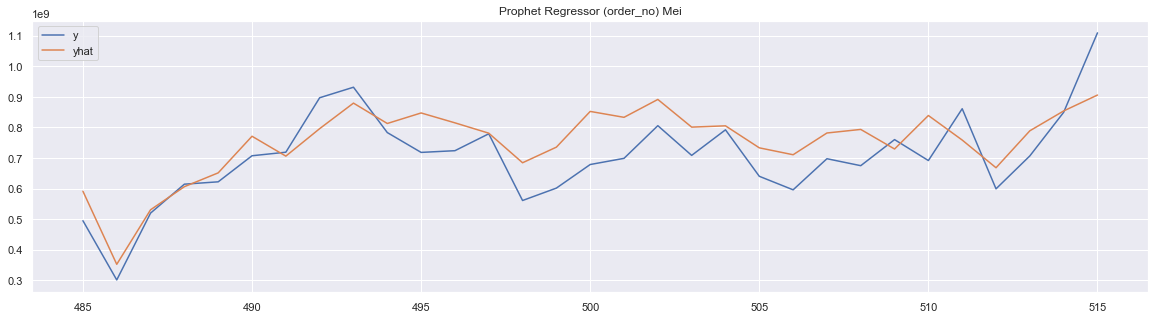

In [153]:
plt.figure(figsize = (20,5))
data_smp_mei_reg_test['y'].plot(legend = True)
dsmr_forecast['yhat'].loc[485:].plot(legend = True)
plt.title('Prophet Regressor (order_no) Mei')

Text(0.5, 1.0, 'Prophet Regressor (order_no)')

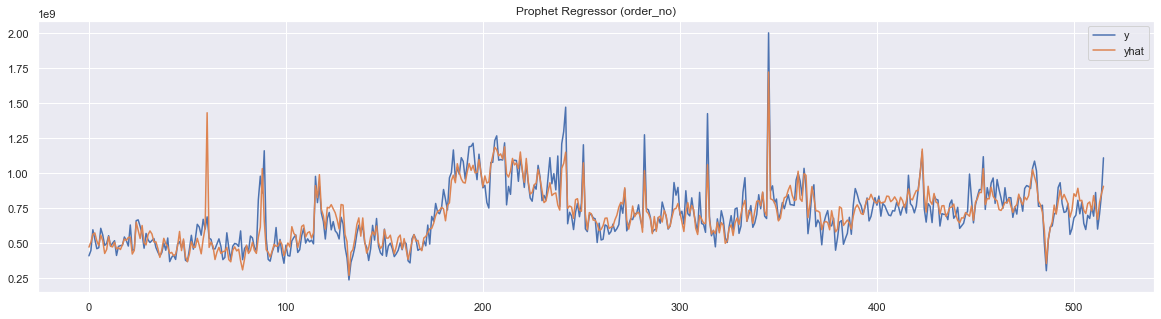

In [154]:
plt.figure(figsize = (20,5))
data_smp_mei_reg['y'].plot(legend = True)
dsmr_forecast['yhat'].plot(legend = True)
plt.title('Prophet Regressor (order_no)')

In [155]:
mean_squared_error(data_smp_mei_reg_test['y'], dsmr_forecast['yhat'].loc[485:], squared = False)

95446222.83550587

In [156]:
mape(data_smp_mei_reg_test['y'], dsmr_forecast['yhat'].loc[485:]) # Testing

11.743369846878254

In [157]:
mape(data_smp_mei_reg_train['y'], dsmr_forecast['yhat'].loc[:484]) # Train

9.204028293859851

In [158]:
# Training Difference
#print('Sum: ',sum(abs(data_smp_mei_reg_train['y']- dsmr_forecast['yhat'].loc[:484]))) 
print('MAE: ', np.mean(abs(data_smp_mei_reg_train['y']- dsmr_forecast['yhat'].loc[:484])))

MAE:  63435779.292907104


In [159]:
# Testing Difference
#print('Sum: ',sum(abs(data_smp_mei_reg_test['y'] -  dsmr_forecast['yhat'].loc[485:]))) 
print('MAE: ', np.mean(abs(data_smp_mei_reg_test['y'] -  dsmr_forecast['yhat'].loc[485:])))

MAE:  80132177.39854613
